# Создание модели машинного обучения для прогнозирования риска ДТП

## Описание проекта

Нам нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

## Цель исследования

Создать модель предсказания ДТП и понимать если возможно ли создать адекватную системы оценки водительского риска при выдаче авто. В итоге нужно сформировать свои идеи создания такой системы.

## Ход исследования

- Подгатовка данных: Загрузка и изучение общей информации из предоставлено датасета.
- Предоработка данных: Обработка пропущенных значений, корректировка типа данных, дубликатов и других аномалий.
- Исследовательский анализ данных: Изучение основных параметров объектов, их распределение, присутствие выбросов,  явление и обработка аномали
- Анализ коррелации: Исследование связи между признаками чтобы понимать если нужно или нет установить несколко признаков
- Построение пайплайн с методом оптимизации чтобы отобрать самую лучшую модель для МО
- Анализ важности признаков чтобы понимать какие признаки важны и какие нет
- Исследование одново из наиболее важных факторов риска и рекомендаций, чтобы избежать этого риска.

# Загрузка данных и первичное исследование таблиц

In [3]:
# установка модулей
!pip install sweetviz

!pip install -U -q seaborn
!pip install -U -q scikit-learn

!pip install -q missingno

!pip install -q phik 

!pip install -U -q shap

!pip install -U -q matplotlib

!pip install -q numpy==1.24.4

!pip install -U numba 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.26.0 requires pandas<2.2.0,>=1.1, but you have pandas 2.2.3 which is incompatible.
sktime 0.26.0 requires scikit-learn<1.5.0,>=0.24, but you have scikit-learn 1.6.1 which is incompatible.
pycaret 3.3.2 requires matplotlib<3.8.0, but you have matplotlib 3.10.1 which is incompatible.
pycaret 3.3.2 requires pandas<2.2.0, but you have pandas 2.2.3 which is incompatible.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.26.0 requires pandas<2.2.0,>=1.1, but you have pandas 2.2.3 which is incompatible.
sktime 0.26.0 requires scikit-learn<1.5.0,>=0.24, but you have s

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import missingno as msno
import sweetviz as sv
import lightgbm as lgb
import shap

from sqlalchemy import create_engine

# train_test_split
from sklearn.model_selection import train_test_split

# Encoders
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import category_encoders as ce
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


# загружаем класс pipeline
#from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import RandomizedSearchCV

# загружаем функцию для работы с метриками

from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

shap.initjs()

## Подключенние к базы

In [5]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

In [6]:
db_config_connection = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [7]:
engine = create_engine(db_config_connection, echo=False)

## Загрузка таблицы parties

In [8]:
query_parties_head = '''
            SELECT *
            FROM parties
            LIMIT 5
'''

In [9]:
df_parties_head = pd.read_sql_query(query_parties_head, con = engine)

In [10]:
df_parties_head.head(5)

id  case_id  party_number   party_type  at_fault  insurance_premium  \
0  22  3899454             1   road signs         1               29.0   
1  23  3899454             2   road signs         0                7.0   
2  29  3899462             2          car         0               21.0   
3  31  3899465             2   road signs         0               24.0   
4  41  3899478             2  road bumper         0                NaN   

          party_sobriety party_drug_physical  cellphone_in_use  
0  had not been drinking                None                 0  
1  had not been drinking                None                 0  
2  had not been drinking                None                 0  
3  had not been drinking                None                 0  
4         not applicable      not applicable                 0

In [11]:
df_parties_head.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5 non-null      int64  
 1   case_id              5 non-null      object 
 2   party_number         5 non-null      int64  
 3   party_type           5 non-null      object 
 4   at_fault             5 non-null      int64  
 5   insurance_premium    4 non-null      float64
 6   party_sobriety       5 non-null      object 
 7   party_drug_physical  1 non-null      object 
 8   cellphone_in_use     5 non-null      int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 492.0+ bytes


Эта таблица касается людей или объектов, попавших в аварию:
- id,  индекс текущей таблицы
- case_id, идентификационный номер в базе данных
- party_number, номер участника происшествия
- party_type, тип участника происшествия
- at_fault, виновность участника
- insurance_premium, сумма страховки
- party_sobriety, состояние участника: физическое или с учётом принятых лекарств
- party_drug_physical, состояние участника: физическое или с учётом принятых лекарств
- cellphone_in_use, наличие телефона в автомобиле (возможности разговаривать по громкой связи)

## Загрузка таблицы collisions

In [12]:
query_collisions_head = '''
                    SELECT *
                    FROM collisions
                    LIMIT 5

'''

In [13]:
df_collisions_head = pd.read_sql_query(query_collisions_head, con = engine)

In [14]:
df_collisions_head.head(5)

case_id county_city_location county_location  distance direction  \
0  4083072                 1942     los angeles     528.0     north   
1  4083075                 4313     santa clara       0.0      None   
2  4083073                 0109         alameda       0.0      None   
3  4083077                 0109         alameda       0.0      None   
4  4083087                 4313     santa clara       0.0      None   

   intersection weather_1 location_type collision_damage  party_count  \
0             0    cloudy       highway     small damage            2   
1             1     clear          None     small damage            1   
2             1     clear          None          scratch            2   
3             1     clear          None          scratch            2   
4             1     clear          None          scratch            2   

  primary_collision_factor   pcf_violation_category type_of_collision  \
0   vehicle code violation       unsafe lane change         sideswipe   
1   vehicle code violation         improper passing        hit object   
2   vehicle code violation         improper turning         broadside   
3   vehicle code violation  automobile right of way         broadside   
4   vehicle code violation                 speeding          rear end   

  motor_vehicle_involved_with road_surface road_condition_1  \
0         other motor vehicle          wet           normal   
1                fixed object          dry           normal   
2         other motor vehicle          dry           normal   
3         other motor vehicle          dry           normal   
4         other motor vehicle          dry             None   

                  lighting control_device collision_date collision_time  
0                 daylight           none     2009-01-22       07:25:00  
1  dark with street lights    functioning     2009-01-03       02:26:00  
2  dark with street lights    functioning     2009-01-11       03:32:00  
3                 daylight    functioning     2009-01-11       10:35:00  
4  dark with street lights    functioning     2009-01-02       22:43:00

In [15]:
df_collisions_head.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      5 non-null      object 
 1   county_city_location         5 non-null      object 
 2   county_location              5 non-null      object 
 3   distance                     5 non-null      float64
 4   direction                    1 non-null      object 
 5   intersection                 5 non-null      int64  
 6   weather_1                    5 non-null      object 
 7   location_type                1 non-null      object 
 8   collision_damage             5 non-null      object 
 9   party_count                  5 non-null      int64  
 10  primary_collision_factor     5 non-null      object 
 11  pcf_violation_category       5 non-null      object 
 12  type_of_collision            5 non-null      object 
 13  motor_vehicle_involved_w

Эта таблица касается столкновений и параметров про нее:
- case_id, идентификационный номер в базе данных
- county_city_location, номер географических районов, где произошло ДТП
- county_location, названия географических районов, где произошло ДТП
- distance, расстояние от главной дороги (метры)
- direction, направление движения
- intersection, является ли место происшествие перекрёстком
- weather_1, погода
- location_type, тип дороги,
- collision_damage, серьёзность происшествия
- party_count, количество участников
- primary_collision_factor, основной фактор аварии
- pcf_violation_category, категория нарушения
- type_of_collision, тип аварии
- motor_vehicle_involved_with, ополнительные участники ДТП
- road_surface, состояние дороги
- road_condition_1, дорожное состояние
- lighting, освещение
- control_device, стройство управления
- collision_date, дата происшествия
- collision_time, время происшествия

## Загрузка таблицы vehicles

In [16]:
query_vehicles_head = '''
                SELECT *
                FROM vehicles
                LIMIT 5
'''

In [17]:
df_vehicles_head = pd.read_sql_query(query_vehicles_head, con = engine)

In [18]:
df_vehicles_head.head()

id  case_id  party_number vehicle_type vehicle_transmission  \
0  1175713  5305032             2        sedan               manual   
1        1  3858022             1        sedan                 auto   
2  1175712  5305030             1        sedan                 auto   
3  1175717  5305033             3        sedan                 auto   
4  1175722  5305034             2        sedan                 auto   

   vehicle_age  
0            3  
1            3  
2            3  
3            5  
4            5

In [19]:
df_vehicles_head.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    5 non-null      int64 
 1   case_id               5 non-null      object
 2   party_number          5 non-null      int64 
 3   vehicle_type          5 non-null      object
 4   vehicle_transmission  5 non-null      object
 5   vehicle_age           5 non-null      int64 
dtypes: int64(3), object(3)
memory usage: 372.0+ bytes


В данной таблице представлена информация о транспортных средствах, попавших в ДТП:
- id,  индекс текущей таблицы
- case_id, идентификационный номер в базе данных
- party_number, номер участника происшествия
- vehicle_type, тип кузова
- vehicle_transmission, тип КПП
- vehicle_age, возраст автомобиля (в годах)

## Загрузка таблицы case_ids

In [20]:
query_case_head = '''
                SELECT *
                FROM case_ids
                LIMIT 5
'''

In [21]:
df_case_head = pd.read_sql_query(query_case_head, con = engine)

In [22]:
df_case_head.head()

case_id db_year
0  0081715    2021
1  0726202    2021
2  3858022    2021
3  3899441    2021
4  3899442    2021

In [23]:
df_case_head.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   case_id  5 non-null      object
 1   db_year  5 non-null      object
dtypes: object(2)
memory usage: 212.0+ bytes


Эта таблица содержит:
- case_id, идентификационный номер в базе данных
- db_year, год, когда авария произошла

## Вывод

Все таблицы имеют набор данных. Количество таблиц соответствует условию задачи. 
Имеется общий ключ для связи таблиц - 'case_id'. 

#  Статистический анализ факторов ДТП

## Годы в которых происходили наибольшее количество аварий. 

In [24]:
query_year_accidents = '''
                    SELECT EXTRACT(YEAR FROM collision_date) AS collision_year, 
                           EXTRACT(MONTH FROM collision_date) AS collision_month, 
                            COUNT(*) AS nb_accidents
                    FROM collisions
                    GROUP BY collision_year, collision_month
                    ORDER BY nb_accidents DESC
'''

In [25]:
df_year_accidents = pd.read_sql_query(query_year_accidents, con = engine)

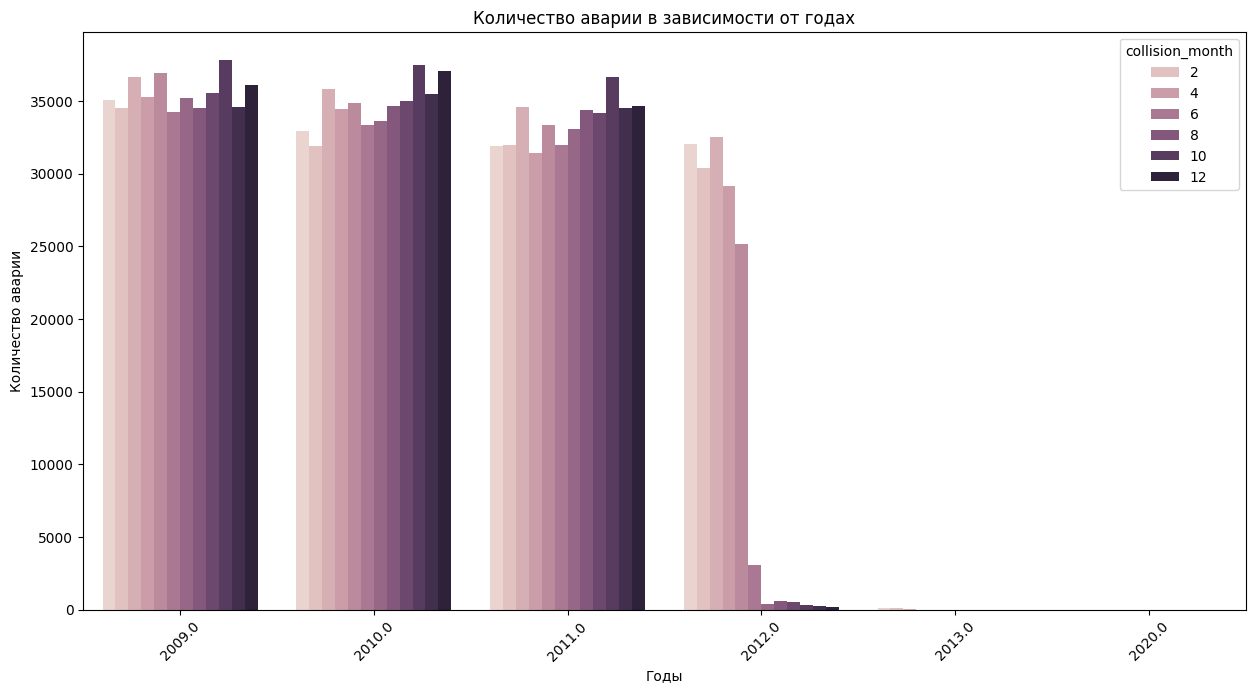

In [26]:
fig, ax = plt.subplots(figsize=(15,7.5))

sns.barplot(data=df_year_accidents, x='collision_year', y='nb_accidents', hue='collision_month');
ax.set_title('Количество аварии в зависимости от годах') 
ax.set_xlabel('Годы');
plt.xticks(rotation=45) 
ax.set_ylabel('Количество аварии');

## Месяцы в которых происходили наибольшее количество аварий. 

In [27]:
query_month_accidents = '''
                    SELECT EXTRACT(MONTH FROM collision_date) AS collision_month, 
                            COUNT(*) AS nb_accidents
                    FROM collisions
                    WHERE EXTRACT(YEAR FROM collision_date) IN (2009, 2010, 2011)
                    GROUP BY collision_month
                    ORDER BY nb_accidents DESC
'''

In [28]:
df_month_accidents = pd.read_sql_query(query_month_accidents, con = engine)

In [29]:
df_month_accidents

collision_month  nb_accidents
0              10.0        111933
1              12.0        107745
2               3.0        107036
3               5.0        105148
4               9.0        104649
5              11.0        104517
6               8.0        103467
7               7.0        101835
8               4.0        101032
9               1.0         99880
10              6.0         99531
11              2.0         98373

In [30]:
# Преобразуем числа месяцев с их названиями.
dict_months_name = {
    1.0 : 'January',
    2.0 : 'February',
    3.0 : 'March', 
    4.0 : 'April',
    5.0 : 'May',
    6.0 : 'June',
    7.0 : 'July',
    8.0 : 'August',
    9.0 : 'September',
    10.0 : 'October',
    11.0 : 'November',
    12.0 : 'December'  
}
df_month_accidents['collision_month'] = df_month_accidents['collision_month'].map(dict_months_name)

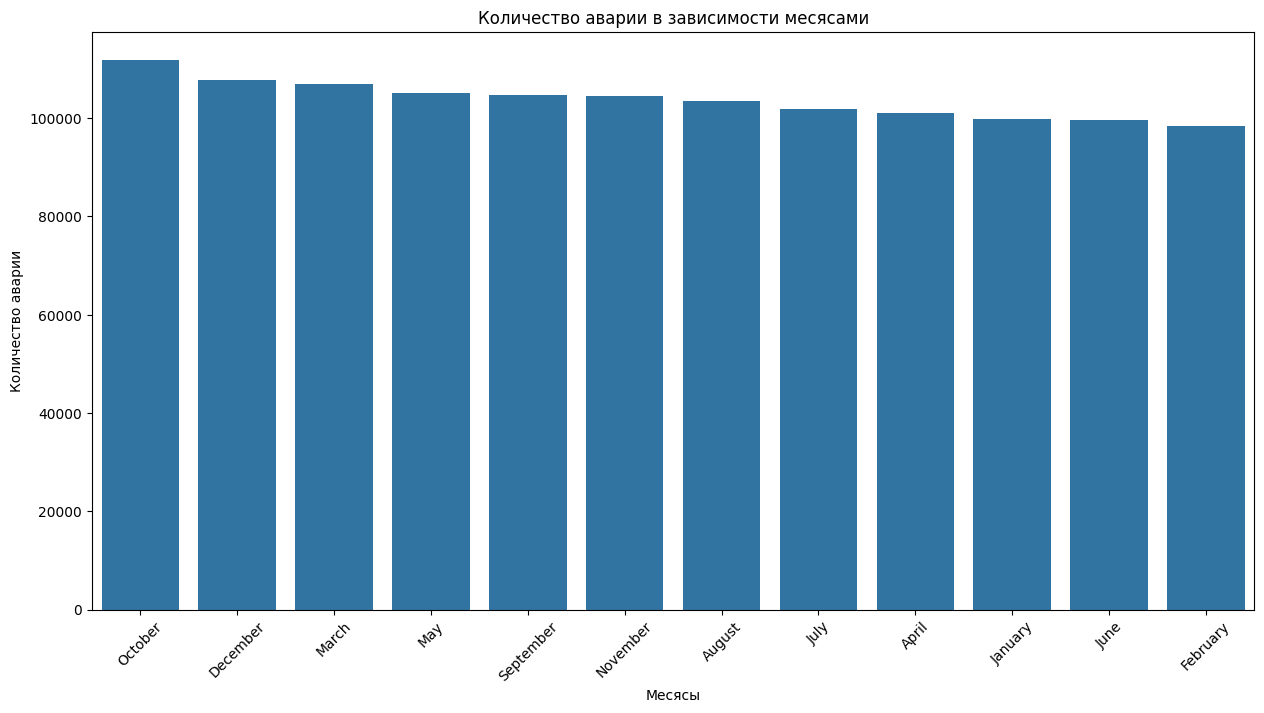

In [31]:
fig, ax = plt.subplots(figsize=(15,7.5))

sns.barplot(data=df_month_accidents, x='collision_month', y='nb_accidents');
ax.set_title('Количество аварии в зависимости месясами') 
ax.set_xlabel('Месясы');
plt.xticks(rotation=45) 
ax.set_ylabel('Количество аварии');

Мы видим, что месяцы, в котором произошло больше всего ДТП — октябрь (Вероятно, в этом месяце происходит много событий, связанных с Хэллоуином), декабрь (в этом месяце происходит много событий, связанных с Рождеством) и март (весенних каникулы).

## Потенциалние подзапосы

Подзапосы которы моно давать:
   - Найдите дни, когда произошло больше всего несчастных случаев
    
   - Найдите тип места (location_type), где произошло большинство аварий
    
   - Найтите долю аварий, в которых участвуют внешние факторы (знак, состояние дороги, погода).
    
   - Найтите, увеличится ли расстояние и количество участников в случае несчастного случая со смертельным исходом
    
   - Покажите долю ДТП, связанных с употреблением алкоголя, наркотиков, физической усталости и использования мобильных телефонов, для каждого дня недели.
    
   - Укажите для каждой категории нарушений долю ДТП со смертельным исходом в общем количестве ДТП, в общем количестве ДТП и по данной категории. Укажите среднюю страховую премию и отклонение от нее ДТП со смертельным исходом для каждой категории нарушений.

## Доля ДТП со смертельным исходом по каждой категории нарушений

In [32]:
# Для этого запроса мы возьмем случай, когда виноват драйвер at_fault=1
query_viol_dam = '''
WITH t1 AS (
         SELECT pcf_violation_category,
                COUNT(*) OVER() AS total_fatal
        FROM collisions AS c
        JOIN parties AS p ON p.case_id=c.case_id 
        WHERE collision_damage = 'fatal' 
              AND at_fault=1
),
t2 AS (
         SELECT pcf_violation_category,
                COUNT(*) AS total_accident_per_violation
        FROM collisions AS c
        JOIN parties AS p ON p.case_id=c.case_id
        WHERE at_fault=1
        GROUP BY pcf_violation_category
),
t3 AS (
         SELECT pcf_violation_category,
                AVG(insurance_premium) AS average_sum_insurance
        FROM collisions AS c
        JOIN parties AS p ON p.case_id=c.case_id
        WHERE at_fault=1
        GROUP BY pcf_violation_category
),
t4 AS (
         SELECT pcf_violation_category,
                AVG(insurance_premium) AS average_sum_insurance_fatal
        FROM collisions AS c
        JOIN parties AS p ON p.case_id=c.case_id
        WHERE collision_damage = 'fatal' AND at_fault=1
        GROUP BY pcf_violation_category
)

SELECT t1.pcf_violation_category,
      (COUNT(*)*100.0)/t1.total_fatal AS share_of_fatal_accident,
      (COUNT(*)*100.0)/t2.total_accident_per_violation AS share_of_fatal_accident_per_violation_category,
      t3.average_sum_insurance,
      (t4.average_sum_insurance_fatal-t3.average_sum_insurance)*100.0/t3.average_sum_insurance 
      AS deviation_from_avg_category_for_fatal_accident
FROM t1
JOIN t2 ON t1.pcf_violation_category = t2.pcf_violation_category
JOIN t3 ON t1.pcf_violation_category = t3.pcf_violation_category
JOIN t4 ON t1.pcf_violation_category = t4.pcf_violation_category
GROUP BY t1.pcf_violation_category, t1.total_fatal, 
        t2.total_accident_per_violation, 
        t3.average_sum_insurance,
        t4.average_sum_insurance_fatal
ORDER BY share_of_fatal_accident DESC
    
'''

In [33]:
df_viol_dam = pd.read_sql_query(query_viol_dam, con=engine)

In [34]:
df_viol_dam

pcf_violation_category  share_of_fatal_accident  \
0                          dui                21.424344   
1             improper turning                21.384889   
2                     speeding                16.206352   
3         pedestrian violation                14.164529   
4      automobile right of way                 6.776485   
5           wrong side of road                 6.194516   
6    traffic signals and signs                 4.981259   
7      pedestrian right of way                 3.245216   
8           unsafe lane change                 2.130598   
9             improper passing                 0.798974   
10   other hazardous violation                 0.512922   
11  unsafe starting or backing                 0.374827   
12      other improper driving                 0.226869   
13       following too closely                 0.147958   
14                     unknown                 0.138094   
15            impeding traffic                 0.118367   
16           hazardous parking                 0.108503   
17             other equipment                 0.078911   
18                      lights                 0.059183   
19                      brakes                 0.019728   

    share_of_fatal_accident_per_violation_category  average_sum_insurance  \
0                                         1.997664              33.850716   
1                                         0.927153              36.911526   
2                                         0.379114              35.657487   
3                                         9.500496              32.257429   
4                                         0.443649              39.589089   
5                                         1.916036              35.225375   
6                                         0.767256              39.709614   
7                                         2.148221              45.478439   
8                                         0.245491              39.379984   
9                                         0.679131              39.047280   
10                                        0.382972              39.861039   
11                                        0.069931              40.515634   
12                                        0.354010              39.711719   
13                                        0.051024              35.620014   
14                                        0.603188              30.949950   
15                                        1.610738              41.884494   
16                                        0.644783              39.980601   
17                                        0.465658              40.931982   
18                                        2.898551              32.202073   
19                                        0.675676              33.359833   

    deviation_from_avg_category_for_fatal_accident  
0                                         0.673905  
1                                        15.161145  
2                                         5.883871  
3                                        47.485073  
4                                        19.887130  
5                                        22.342117  
6                                         4.328092  
7                                         0.366596  
8                                         9.499926  
9                                        -4.673969  
10                                       15.551430  
11                                       15.614888  
12                                       10.672621  
13                                       33.258418  
14                                        2.046476  
15                                       29.124954  
16                                       43.069384  
17                                        5.663098  
18                                       50.300885  
19                                       16.907061

### Общее доля ДТП по каждой категории нарушений

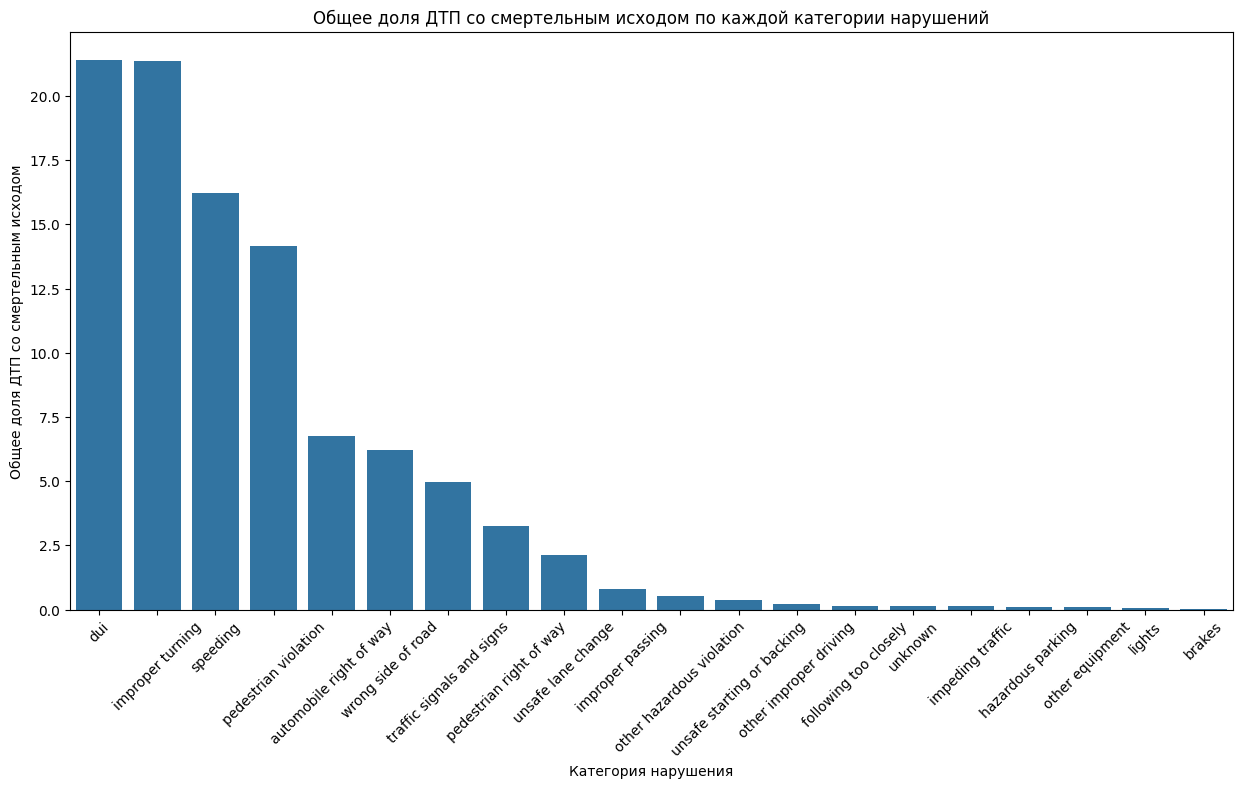

In [35]:
fig, ax = plt.subplots(figsize=(15,7.5))
sns.barplot(data=df_viol_dam, x='pcf_violation_category', y='share_of_fatal_accident');
ax.set_title('Общее доля ДТП со смертельным исходом по каждой категории нарушений') 
ax.set_xlabel('Категория нарушения');
plt.xticks(rotation=45) 
ax.set_ylabel('Общее доля ДТП со смертельным исходом');

На этой диаграмме мы видим, чтовождения в нетрезвом состоянии являются наиболее фатальными нарушениями (21%), за ними следуют неправильный поворот (21%), превышение скорости (16%) и нарушение правил пешеходов (14%).

### Доля ДТП по каждой категории нарушений

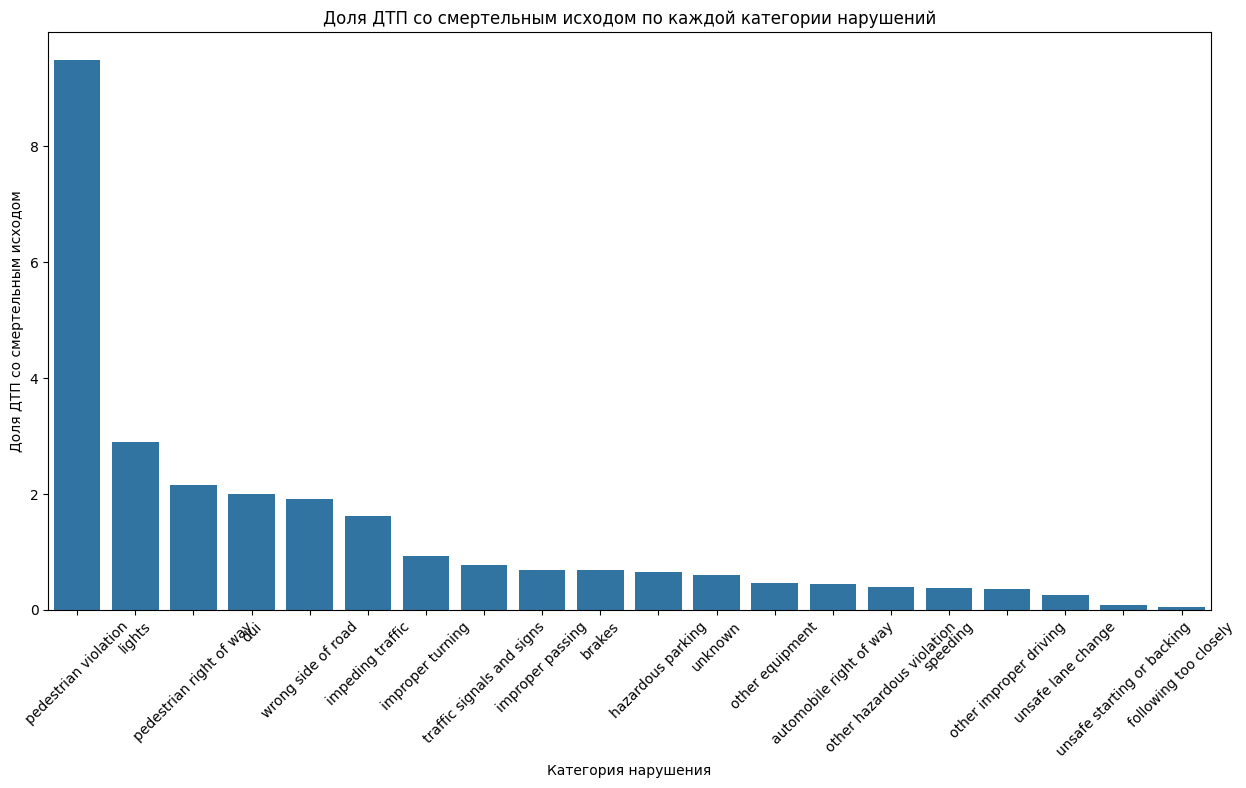

In [36]:
fig, ax = plt.subplots(figsize=(15,7.5))
sns.barplot(data=df_viol_dam.sort_values(by='share_of_fatal_accident_per_violation_category', ascending=False),\
            x='pcf_violation_category', \
            y='share_of_fatal_accident_per_violation_category');
ax.set_title('Доля ДТП со смертельным исходом по каждой категории нарушений') 
ax.set_xlabel('Категория нарушения');
plt.xticks(rotation=45) 
ax.set_ylabel('Доля ДТП со смертельным исходом');

Нарушение правил пешеходов оказалось самым смертоносным нарушением.  Среди наиболее важных из категорий которие приводят к смертельным исходом после нарушения пешеходов : ДТП из-за светофоров, право проезда для пешеходов, вождения в нетрезвом состоянии, неправильная сторона дороги, надвигающееся дорожно-транспортное.

### Средняя общая сумма страховки нарушателых по каждой категории нарушений

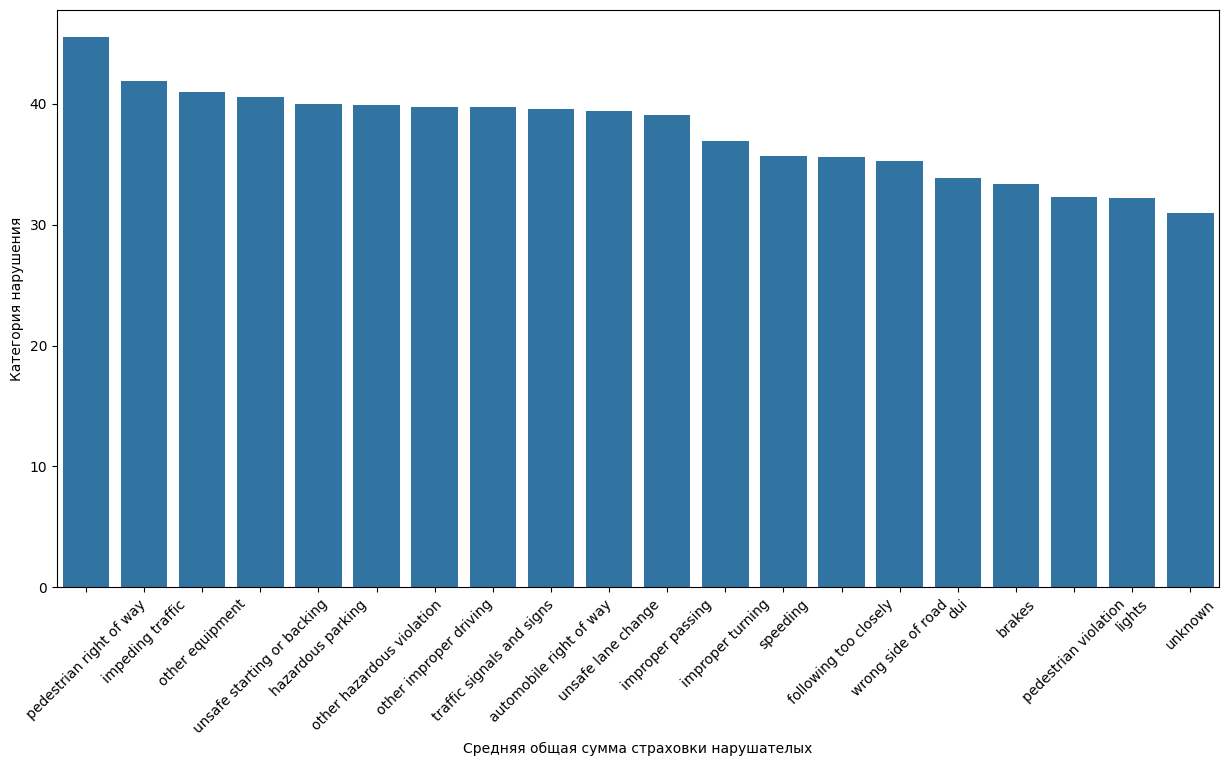

In [37]:
fig, ax = plt.subplots(figsize=(15,7.5))
sns.barplot(data=df_viol_dam.sort_values(by='average_sum_insurance', ascending=False),\
                                         x='pcf_violation_category', \
                                         y='average_sum_insurance');
ax.set_title('') 
ax.set_xlabel('Средняя общая сумма страховки нарушателых');
plt.xticks(rotation=45) 
ax.set_ylabel('Категория нарушения');

Мы видим, что страховые взносы одни из самых низких за вождения в нетрезвом состоянии, нарушение пешеходов, торможение, светофор, неправильный поворот, превышение скорости, выезд на встречную полосу. Поскольку для молодых людей страховка обходится дороже, мы понимаем, какие нарушения они совершают.

### Отклонение от средней страховой суммы по категориям нарушений

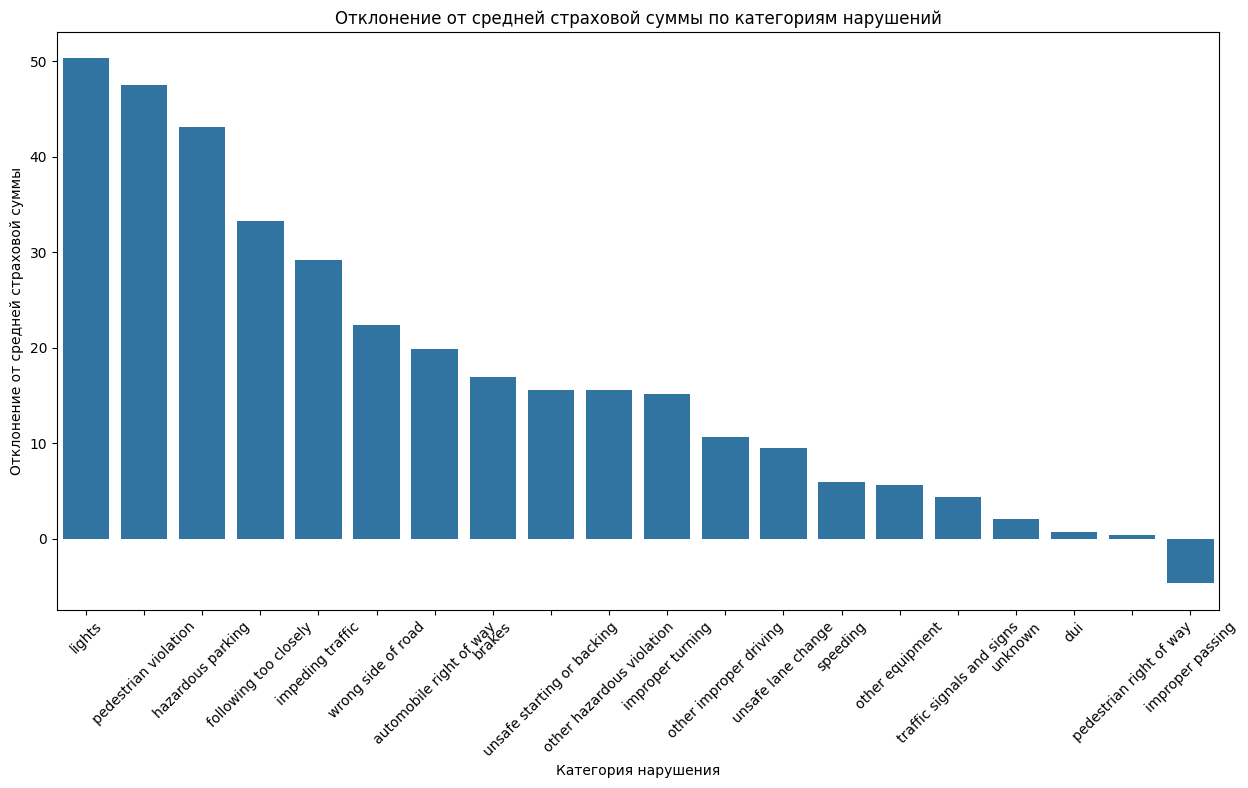

In [38]:
fig, ax = plt.subplots(figsize=(15,7.5))
sns.barplot(data=df_viol_dam.sort_values(by='deviation_from_avg_category_for_fatal_accident', ascending=False),\
                                         x='pcf_violation_category', \
                                         y='deviation_from_avg_category_for_fatal_accident');
ax.set_title(f'Отклонение от средней страховой суммы по категориям нарушений') 
ax.set_xlabel('Категория нарушения');
plt.xticks(rotation=45) 
ax.set_ylabel('Отклонение от средней страховой суммы');


Если мы примем во внимание, что более молодой водитель платит больше всего, а пожилой водитель платит меньше, мы увидим, что, вообще говоря, более молодой водитель может быть тем, кто нарушает правила пешехода, то есть нарушает правила на противоположной стороне дороги. За превышение скорости и а для дуи не совсем понятно, так как отклонение не такое уж большое.

### Вывод

20% ДТП со смертельным исходом происходят из-за вождения в нетрезвом состоянии, 2% ДТП, произошедших из-за вождения в нетрезвом состоянии, заканчиваются смертельным исходом, а у водителя в ДТП самая низкая страховка, что может показаться странным, поскольку страховка является признаком хорошего водительского стажа. Мы видим, что смертельными ДТП являются неправильное вождение, нарушение правил дорожного движения, превышение скорости, нарушение пешеходов.

## Влияние водителей на количество ДТП по каждому дню недели

In [39]:
query_time_driver = '''
WITH t1 AS (
            SELECT EXTRACT(DOW FROM collision_date) AS day_of_week,
                   COUNT(*) AS total_nb_accident
            FROM collisions
            GROUP BY day_of_week
        ),
    t2 AS (
            SELECT EXTRACT(DOW FROM collision_date) AS day_of_week,
                   COUNT(DISTINCT p.case_id) nb_accident_unsober
            FROM collisions AS c
            JOIN parties AS p ON p.case_id = c.case_id
            WHERE party_sobriety NOT IN ('had not been drinking', 'not applicable')
                    AND party_sobriety IS NOT NULL
            GROUP BY day_of_week
    ),
    t3 AS (
            SELECT EXTRACT(DOW FROM collision_date) AS day_of_week,
                   COUNT(DISTINCT p.case_id) nb_accident_impaired_drug_sleep
            FROM collisions AS c
            JOIN parties AS p ON p.case_id = c.case_id
            WHERE party_drug_physical != 'not applicable'
                    AND party_drug_physical IS NOT NULL
            GROUP BY day_of_week
    ),
    t4 AS (
            SELECT EXTRACT(DOW FROM collision_date) AS day_of_week,
                   COUNT(DISTINCT p.case_id) nb_accident_w_cellphone
            FROM collisions AS c
            JOIN parties AS p ON p.case_id = c.case_id
            WHERE cellphone_in_use = 1
            GROUP BY day_of_week
    )
    SELECT t1.day_of_week,
           ROUND((t2.nb_accident_unsober*100.0)/(t1.total_nb_accident),2) AS share_of_unsober_accident,
           ROUND((t3.nb_accident_impaired_drug_sleep*100.0)/(t1.total_nb_accident),2) AS share_of_dui_drug,
           ROUND((t4.nb_accident_w_cellphone*100.0)/(t1.total_nb_accident),2) AS share_of_accident_due_to_cellphone
    FROM t1
    JOIN t2 ON t1.day_of_week = t2.day_of_week
    JOIN t3 ON t1.day_of_week = t3.day_of_week
    JOIN t4 ON t1.day_of_week = t4.day_of_week
    ORDER BY share_of_unsober_accident DESC, share_of_dui_drug DESC, share_of_accident_due_to_cellphone DESC
'''

In [40]:
df_driver = pd.read_sql_query(query_time_driver, con=engine)

In [41]:
df_driver

day_of_week  share_of_unsober_accident  share_of_dui_drug  \
0          0.0                      39.19              22.43   
1          6.0                      35.17              20.92   
2          5.0                      25.54              17.75   
3          1.0                      22.76              17.29   
4          4.0                      22.60              16.76   
5          3.0                      21.41              16.42   
6          2.0                      20.63              16.27   

   share_of_accident_due_to_cellphone  
0                                2.10  
1                                2.12  
2                                2.38  
3                                2.32  
4                                2.42  
5                                2.43  
6                                2.42

In [42]:

dict_days_name = {
    0.0 : 'Sunday',
    1.0 : 'Monday',
    2.0 : 'Tuesday',
    3.0 : 'Wednesday', 
    4.0 : 'Thursday',
    5.0 : 'Friday',
    6.0 : 'Saturday'
}
df_driver['day_of_week'] = df_driver['day_of_week'].map(dict_days_name)

### Влияние водителей которые выпили алкогол на количество ДТП по каждому дню недели

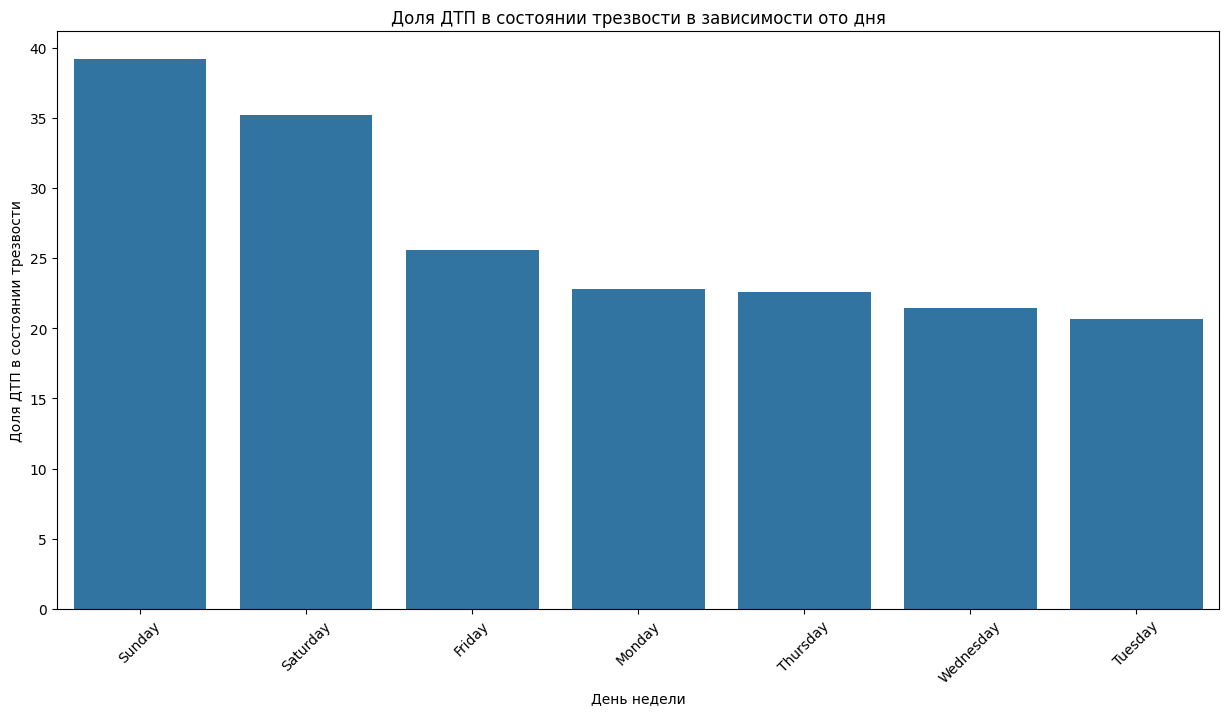

In [43]:
fig, ax = plt.subplots(figsize=(15,7.5))
sns.barplot(data=df_driver.sort_values(by='share_of_unsober_accident', ascending=False), \
            x='day_of_week',\
            y='share_of_unsober_accident');
ax.set_title('Доля ДТП в состоянии трезвости в зависимости ото дня') 
ax.set_xlabel('День недели');
plt.xticks(rotation=45) 
ax.set_ylabel('Доля ДТП в состоянии трезвости');

Когда дело касается алкоголя, у нас увеличивается количество ДТП в выходные и в пятницу (вероятно, ночью).

### Влияние водителей принявшей наркотики или ослабленный на количество ДТП по каждому дню недели

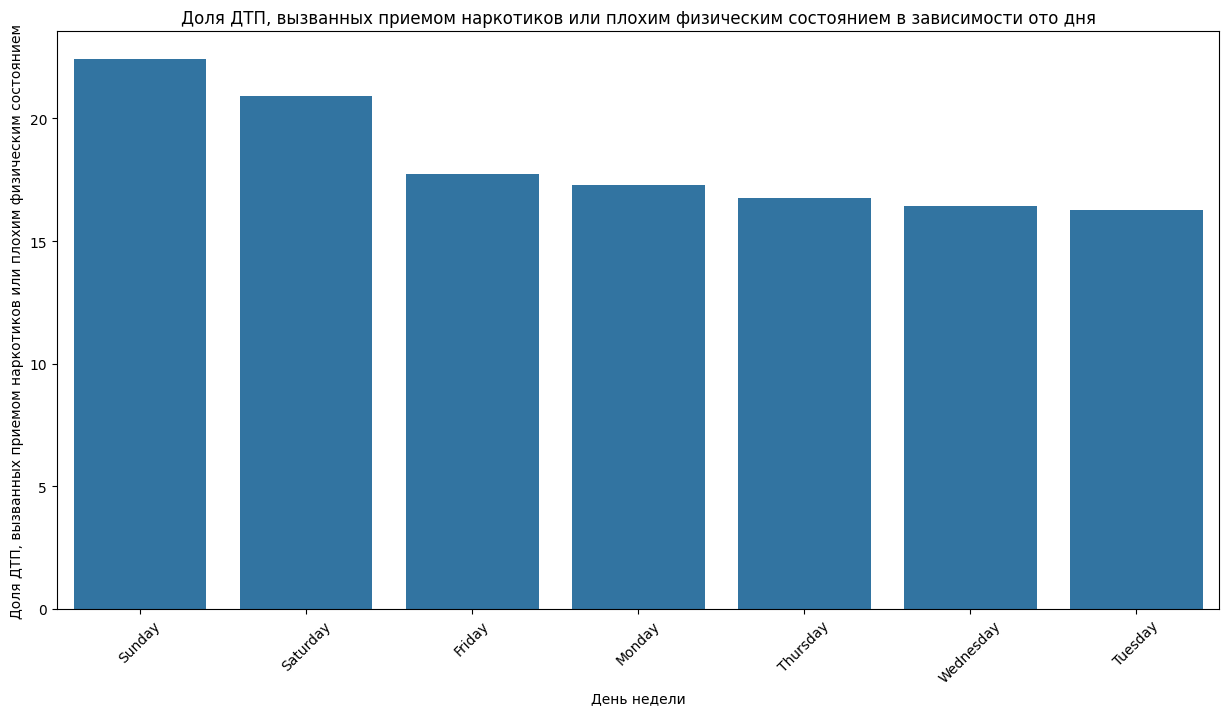

In [44]:
fig, ax = plt.subplots(figsize=(15,7.5))
sns.barplot(data=df_driver.sort_values(by='share_of_dui_drug', ascending=False),\
            x='day_of_week',\
            y='share_of_dui_drug');
ax.set_title('Доля ДТП, вызванных приемом наркотиков или плохим физическим состоянием в зависимости ото дня') 
ax.set_xlabel('День недели');
plt.xticks(rotation=45) 
ax.set_ylabel('Доля ДТП, вызванных приемом наркотиков или плохим физическим состоянием');

Когда речь идет о наркотиках и усталости, у нас тоже увеличивается количество ДТП в выходные и в пятницу (вероятно, ночью).

### Влияние водителей который исползовали телефон  на количество ДТП по каждому дню недели

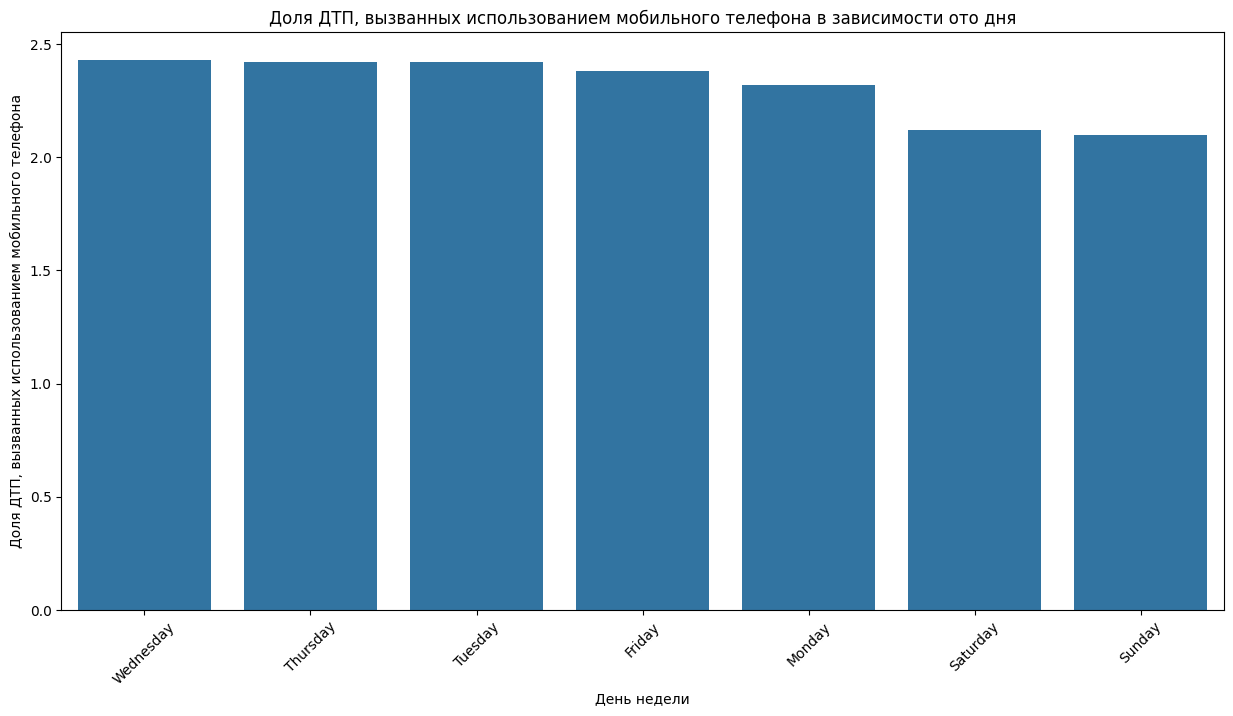

In [45]:
fig, ax = plt.subplots(figsize=(15,7.5))
sns.barplot(data=df_driver.sort_values(by='share_of_accident_due_to_cellphone', ascending=False), \
            x='day_of_week', \
            y='share_of_accident_due_to_cellphone');
ax.set_title('Доля ДТП, вызванных использованием мобильного телефона в зависимости ото дня') 
ax.set_xlabel('День недели');
plt.xticks(rotation=45) 
ax.set_ylabel('Доля ДТП, вызванных использованием мобильного телефона');

Связь между ДТП и использованием смартфонов увеличилась в рабочие дни, поскольку, безусловно, все больше людей используют телефоны для работы.

### Вывод

Мы видим это в случае совершения преступления в нетрезвом состоянии, если водитель находится в состоянии алкогольного опьянения или употребляет наркотики, это увеличивает количество ДТП в выходные дни. Однако мы видим, что ДТП связаны с увеличением количества мобильных телефонов в рабочие дни, что может быть логичным, если в это время работает больше людей. 
Похоже, что между алкоголем, наркотиками, усталостью и использованием мобильных телефонов алкоголь имеет наибольшее влияние.

## Влияние водителей на тяжесть ДТП

In [46]:
query_damage_driver = '''
WITH t1 AS (
            SELECT collision_damage,
                   COUNT(*) AS total_nb_accident
            FROM collisions
            GROUP BY collision_damage
        ),
    t2 AS (
            SELECT collision_damage,
                   COUNT(DISTINCT p.case_id) nb_accident_unsober
            FROM collisions AS c
            JOIN parties AS p ON p.case_id = c.case_id
            WHERE party_sobriety NOT IN ('had not been drinking', 'not applicable')
                    AND party_sobriety IS NOT NULL
            GROUP BY collision_damage
    ),
    t3 AS (
            SELECT collision_damage,
                   COUNT(DISTINCT p.case_id) nb_accident_impaired_drug_sleep
            FROM collisions AS c
            JOIN parties AS p ON p.case_id = c.case_id
            WHERE party_drug_physical != 'not applicable'
                 AND party_drug_physical IS NOT NULL
            GROUP BY collision_damage
    ),
    t4 AS (
            SELECT collision_damage,
                   COUNT(DISTINCT p.case_id) nb_accident_w_cellphone
            FROM collisions AS c
            JOIN parties AS p ON p.case_id = c.case_id
            WHERE cellphone_in_use = 1
            GROUP BY collision_damage
    )
    SELECT t1.collision_damage,
           ROUND((t2.nb_accident_unsober*100.0)/(t1.total_nb_accident),2) AS share_of_unsober_accident,
           ROUND((t3.nb_accident_impaired_drug_sleep*100.0)/(t1.total_nb_accident),2) AS share_of_dui_drug,
           ROUND((t4.nb_accident_w_cellphone*100.0)/(t1.total_nb_accident),2) AS share_of_accident_due_to_cellphone
    FROM t1
    JOIN t2 ON t1.collision_damage = t2.collision_damage
    JOIN t3 ON t1.collision_damage = t3.collision_damage
    JOIN t4 ON t1.collision_damage = t4.collision_damage
    ORDER BY share_of_unsober_accident DESC, share_of_dui_drug DESC, share_of_accident_due_to_cellphone DESC
'''

In [47]:
df_driver_damage = pd.read_sql_query(query_damage_driver, con=engine)

In [48]:
df_driver_damage

collision_damage  share_of_unsober_accident  share_of_dui_drug  \
0            fatal                      52.14              41.38   
1    severe damage                      36.83              16.63   
2     small damage                      30.47              22.26   
3    middle damage                      23.87              10.82   
4          scratch                      15.52              10.87   

   share_of_accident_due_to_cellphone  
0                                2.50  
1                                2.16  
2                                2.30  
3                                2.20  
4                                2.43

### Влияние водителей которые выпили алкогол на количество ДТП по степена повреждении

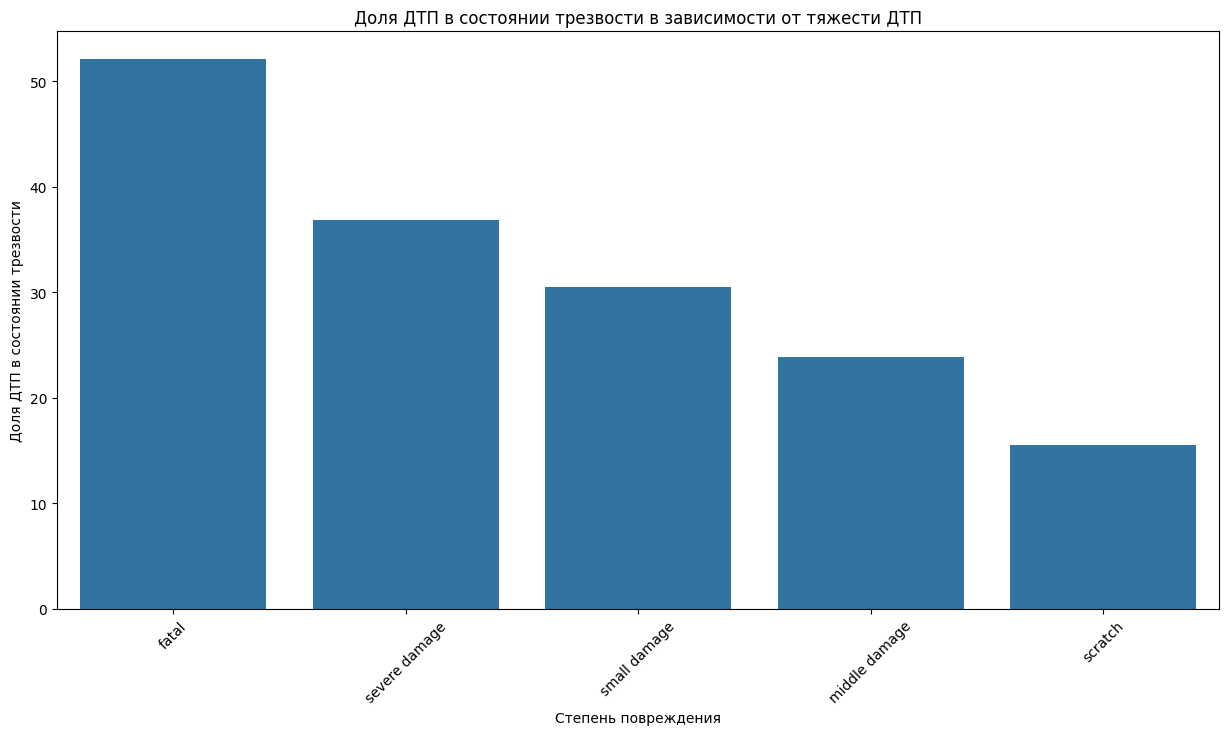

In [49]:
fig, ax = plt.subplots(figsize=(15,7.5))
sns.barplot(data=df_driver_damage.sort_values(by='share_of_unsober_accident', ascending=False), \
            x='collision_damage',\
            y='share_of_unsober_accident');
ax.set_title('Доля ДТП в состоянии трезвости в зависимости от тяжести ДТП') 
ax.set_xlabel('Степень повреждения');
plt.xticks(rotation=45) 
ax.set_ylabel('Доля ДТП в состоянии трезвости');

Мы видим, что когда дело касается алкоголя, большее значение имеет количество ДТП с тяжелыми или смертельными последствиями.

### Влияние водителей которые принимали наркотиком или на состояние уставшим на количество ДТП по степена повреждении

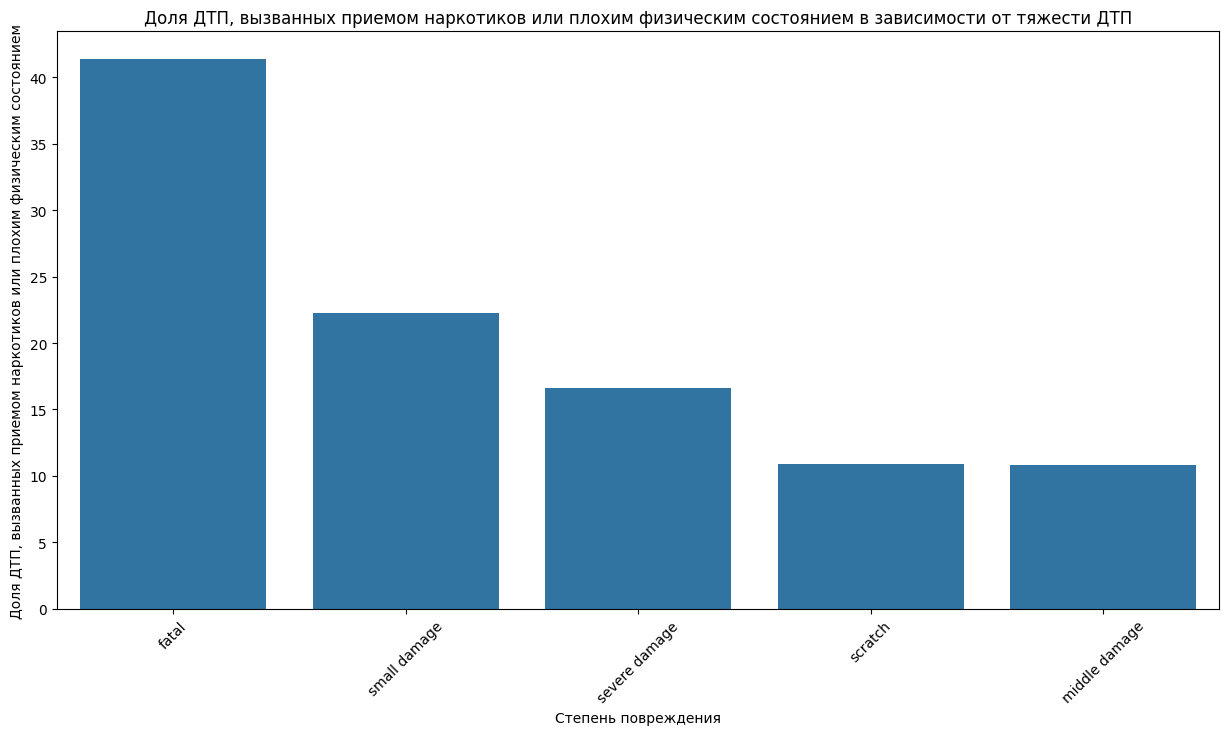

In [50]:
fig, ax = plt.subplots(figsize=(15,7.5))
sns.barplot(data=df_driver_damage.sort_values(by='share_of_dui_drug', ascending=False),\
            x='collision_damage',\
            y='share_of_dui_drug');
ax.set_title('Доля ДТП, вызванных приемом наркотиков или плохим физическим состоянием '
              'в зависимости от тяжести ДТП') 
ax.set_xlabel('Степень повреждения');
plt.xticks(rotation=45) 
ax.set_ylabel('Доля ДТП, вызванных приемом наркотиков или плохим физическим состоянием');

Наркотики и усталость приводят к более фатальным повреждениям.

### Влияние водителей которые использовали мобильном телефоном во время ДТП на количество ДТП по степена повреждении

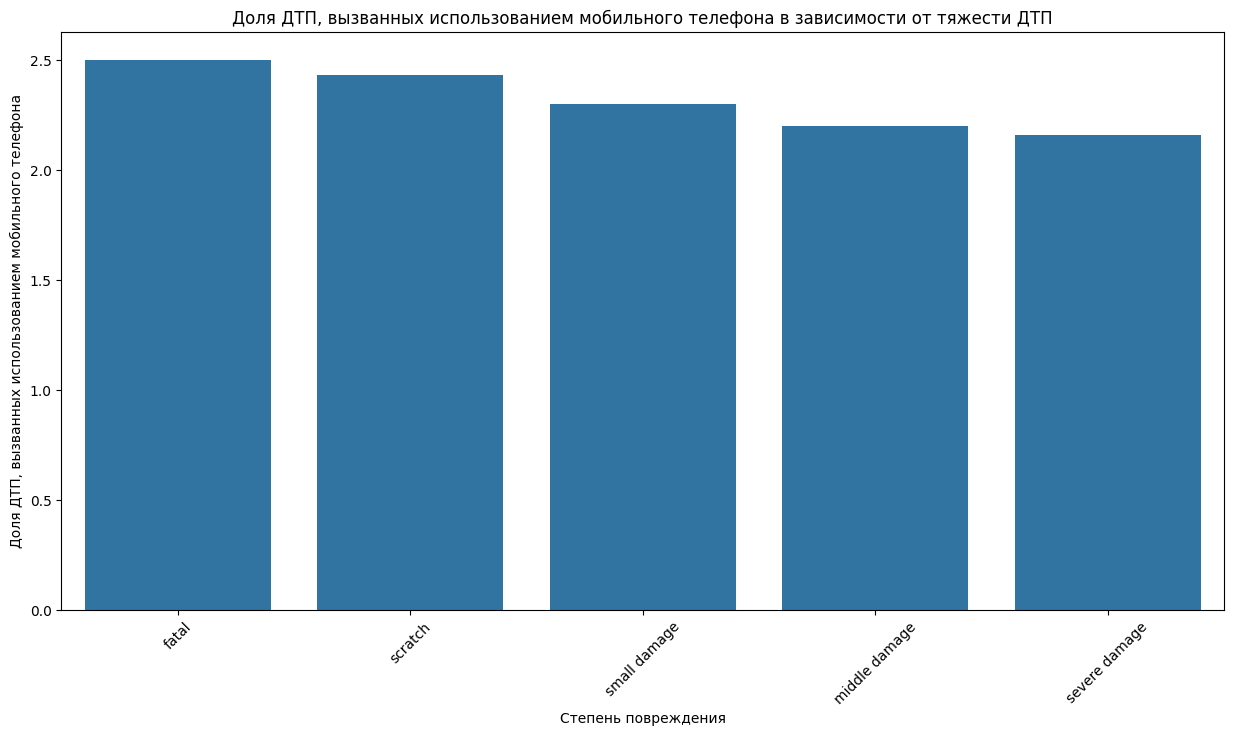

In [51]:
fig, ax = plt.subplots(figsize=(15,7.5))
sns.barplot(data=df_driver_damage.sort_values(by='share_of_accident_due_to_cellphone', ascending=False), \
            x='collision_damage', \
            y='share_of_accident_due_to_cellphone');
ax.set_title('Доля ДТП, вызванных использованием мобильного телефона в зависимости от тяжести ДТП') 
ax.set_xlabel('Степень повреждения');
plt.xticks(rotation=45) 
ax.set_ylabel('Доля ДТП, вызванных использованием мобильного телефона');

Невнимательность из-за использования мобильного телефона приводит к более серьезным повреждениям, а также к большему количеству царапин. Мы не можем точно сказать о серьезности ущерба, причиненного использованием мобильного телефона.

### Вывод

Алкоголь, наркотики, усталость и использование мобильных телефонов приводят к увеличению числа ДТП со смертельным исходом. В случае использования мобильного телефона это менее заметно, чем по остальным параметрам. Мы снова видим, что алкоголь является самым смертоносным фактором в ДТП, исходящим от водителя.

In [52]:
# Удаляем датафрейм, чтобы освободить место в оперативной памяти
del df_viol_dam 
del df_driver 
del df_driver_damage

# Создайте модель для оценки водительского риска

## Набор данных на основе первичного предположения заказчика:

Мы не можем использовать часы как есть, потому что это будет похоже на утечку данных, но когда вы едете, вы, вероятно, знаете, когда времени вы проехали на машине, было ночь или утро, поэтому для нашей модели мы будем использовать период времени вместо часов.

In [53]:
query_df = '''
    WITH t1 AS (
    SELECT p.case_id AS case_id, p.party_number, p.party_type, p.at_fault, p.insurance_premium, p.party_sobriety,
        p.party_drug_physical, p.cellphone_in_use, v.vehicle_type, v.vehicle_transmission, v.vehicle_age
    FROM parties AS p
    JOIN vehicles AS v ON p.case_id=v.case_id AND p.party_number=v.party_number
    )

    SELECT EXTRACT(DOW FROM collision_date) AS collision_day, 
    EXTRACT(HOUR FROM collision_time) AS collision_hour, *
    FROM collisions AS c
    JOIN t1 ON t1.case_id=c.case_id
    WHERE EXTRACT(YEAR FROM collision_date)= 2012   
          AND collision_damage != 'scratch'
          AND party_type = 'car'
    ORDER BY t1.case_id, t1.party_number
'''

In [54]:
df_0 = pd.read_sql_query(query_df, con=engine)

In [55]:
df_0.head(50)

collision_day  collision_hour  case_id county_city_location  \
0             5.0             7.0  5125160                 3712   
1             1.0            12.0  5173738                 3404   
2             2.0            16.0  5269486                 3400   
3             3.0            19.0  5319820                 3607   
4             6.0            13.0  5329109                 3400   
5             6.0            13.0  5329109                 3400   
6             2.0             7.0  5403029                 4313   
7             4.0             5.0  5403030                 1942   
8             5.0             6.0  5403031                 1500   
9             0.0            19.0  5403033                 3711   
10            4.0             4.0  5403034                 3300   
11            0.0            15.0  5403035                 1500   
12            0.0            15.0  5403035                 1500   
13            2.0            12.0  5403036                 3600   
14            5.0             2.0  5403037                 3500   
15            4.0            11.0  5403038                 1942   
16            6.0            18.0  5403039                 3401   
17            6.0            18.0  5403039                 3401   
18            0.0             8.0  5403040                 4000   
19            2.0             0.0  5403042                 1942   
20            2.0             0.0  5403042                 1942   
21            3.0             7.0  5403043                 1200   
22            3.0             7.0  5403043                 1200   
23            0.0            17.0  5403045                 1941   
24            0.0            17.0  5403045                 1941   
25            6.0             4.0  5403046                 1203   
26            0.0            15.0  5403083                 0900   
27            3.0            14.0  5403084                 1942   
28            2.0            19.0  5403085                 3711   
29            2.0            22.0  5403086                 1915   
30            2.0            22.0  5403086                 1915   
31            2.0            15.0  5403119                 3700   
32            2.0            15.0  5403119                 3700   
33            3.0             6.0  5403120                 3600   
34            3.0             6.0  5403120                 3600   
35            4.0            15.0  5403121                 1919   
36            6.0            12.0  5403123                 3900   
37            6.0            12.0  5403123                 3900   
38            1.0            18.0  5403124                 3100   
39            1.0            18.0  5403124                 3100   
40            2.0            17.0  5403125                 3200   
41            2.0            22.0  5403126                 1985   
42            4.0            22.0  5403127                 0400   
43            4.0            22.0  5403127                 0400   
44            6.0            15.0  5403128                 4307   
45            6.0            19.0  5403130                 2900   
46            6.0            18.0  5403131                 2200   
47            6.0            18.0  5403131                 2200   
48            0.0            19.0  5403132                 3020   
49            0.0            19.0  5403132                 3020   

    county_location  distance direction  intersection weather_1 location_type  \
0         san diego       0.0      None           1.0    cloudy          None   
1        sacramento       0.0      None           1.0     clear          None   
2        sacramento       0.0      None           1.0     clear          None   
3    san bernardino       5.0      east           0.0     clear          None   
4        sacramento       0.0      None           1.0     clear          None   
5        sacramento       0.0      None           1.0     clear          None   
6       santa clara

In [56]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   collision_day                56248 non-null  float64
 1   collision_hour               56160 non-null  float64
 2   case_id                      56248 non-null  object 
 3   county_city_location         56248 non-null  object 
 4   county_location              56248 non-null  object 
 5   distance                     56248 non-null  float64
 6   direction                    43230 non-null  object 
 7   intersection                 56073 non-null  float64
 8   weather_1                    56080 non-null  object 
 9   location_type                25932 non-null  object 
 10  collision_damage             56248 non-null  object 
 11  party_count                  56248 non-null  int64  
 12  primary_collision_factor     56137 non-null  object 
 13  pcf_violation_ca

## Отбор факторов, необходимых для модели

Прежде чем отобрать фасторы, нам нужно выдвинуть гипотезу. Увеличивается ли риск возникновения вины с серьезностью ущерба? Мы собираемся выбрать некоторые признаки, которые могут повлиять на повреждение автомобиля и, возможно, на цель «at_fault». Отбор признаков для нашей модели:

In [57]:
selected_features = [
'collision_day', # (collision_date) Дата может повлиять на цель, потому что, как мы видели, 
                 # большинство людей пьют в выходные дни.
'collision_hour', # (collision_time) Время может повлиять на наш целовой признак, например, мы видели, 
                  # что в выходные  дни происходит больше ДТП, связанных с алкоголем, и они определенно происходят 
                  # ночью. Кроме того, этот признак может дать информацию о светимости.
'distance', # Удаленность от главной дороги, возможно, это может дать информацию о том, кто виноват. В зависимости 
            # от того, где находится автомобиль, повреждения могут измениться.
'location_type', # Те же рассуждения, что и для расстояния
'county_city_location', # в зависимости от местоположения может быть больше движения, а чем больше движение, 
                        # тем выше риск аварии
'county_location', # в зависимости от местоположения может быть больше движения, а чем больше движение, 
                    # тем выше риск аварии
'direction',  # в зависимости от местоположения может быть больше движения, а чем больше движение, 
                  # тем выше риск аварии
'intersection', # Похоже, что пересечение является частью объектов location_type (пересечений). По той же причине 
                # чем для фактор 'location_type' мы собираемся отобрать это признак.
'weather_1', # Погода может быть виновата, если она действительно плохая, но, конечно, не большую часть времени 
             # использование этих функций находится под вопросом.
'road_surface', # Дорожное покрытие у всех одинаковое, но если оно плохое из-за погоды, возможно, водитель не 
                  # виноват.
'road_condition_1', # Состояние дороги может быть плохим, и водитель может быть не виноват в аварии.
'lighting', # Может быть темно, без знаков и водитель может быть не виноват
'control_device', # Могут отсутствовать знаки или проблемы со светофорами, что может указывать на то, 
                  # что водитель не виноват.
'vehicle_type', # Некоторыми автомобилями управлять сложнее, чем другими
'insurance_premium', # Это определенно расскажет нам о возрасте и водительском стаже человека. Если цена высока,
                    # это, безусловно, означает, что водитель молодой, с небольшим опытом или с плохим стажем 
                    # вождения. Если цена низкая, значит, человек старше. Однако чем старше водитель, тем выше 
                    # вероятность того, что он может стать причиной аварии.
'party_sobriety', # Это точно повлияет на цель
'party_drug_physical', # Это тоже точно повлияет на цель
'cellphone_in_use', #  Это может повлиять на целовой признак.
'vehicle_transmission', # # Это может дать нам информацию о поле, поскольку среди них, вероятно, более высокая 
                        # доля женщин, которые водят машину на автомате. Мы также можем подумать, что 
                        # автоматическая коробка передач «легче» в управлении, а водитель с автоматической 
                        # коробкой передач может лучше контролировать ситуацию.
'vehicle_age', # Это может повлиять на целовой признак. Например, новые машины быстрее, поэтому, когда речь идет о 
              # скорости, ущерб может быть более серьезным.
'at_fault' # Наш целовой признак
]
selected_features 

['collision_day',
 'collision_hour',
 'distance',
 'location_type',
 'county_city_location',
 'county_location',
 'direction',
 'intersection',
 'weather_1',
 'road_surface',
 'road_condition_1',
 'lighting',
 'control_device',
 'vehicle_type',
 'insurance_premium',
 'party_sobriety',
 'party_drug_physical',
 'cellphone_in_use',
 'vehicle_transmission',
 'vehicle_age',
 'at_fault']

Во-первых, признаки, которые мы сразу удаляем: case_id, id, party_number, party_type, которые помогли нам создать датафрейм, но теперь бесполезны для нашей модели.

In [58]:
df = df_0[selected_features]

## Статистическое исследование отобранных факторов.

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   collision_day         56248 non-null  float64
 1   collision_hour        56160 non-null  float64
 2   distance              56248 non-null  float64
 3   location_type         25932 non-null  object 
 4   county_city_location  56248 non-null  object 
 5   county_location       56248 non-null  object 
 6   direction             43230 non-null  object 
 7   intersection          56073 non-null  float64
 8   weather_1             56080 non-null  object 
 9   road_surface          55900 non-null  object 
 10  road_condition_1      55999 non-null  object 
 11  lighting              56094 non-null  object 
 12  control_device        56033 non-null  object 
 13  vehicle_type          56248 non-null  object 
 14  insurance_premium     55701 non-null  float64
 15  party_sobriety     

### Разработка пропусков

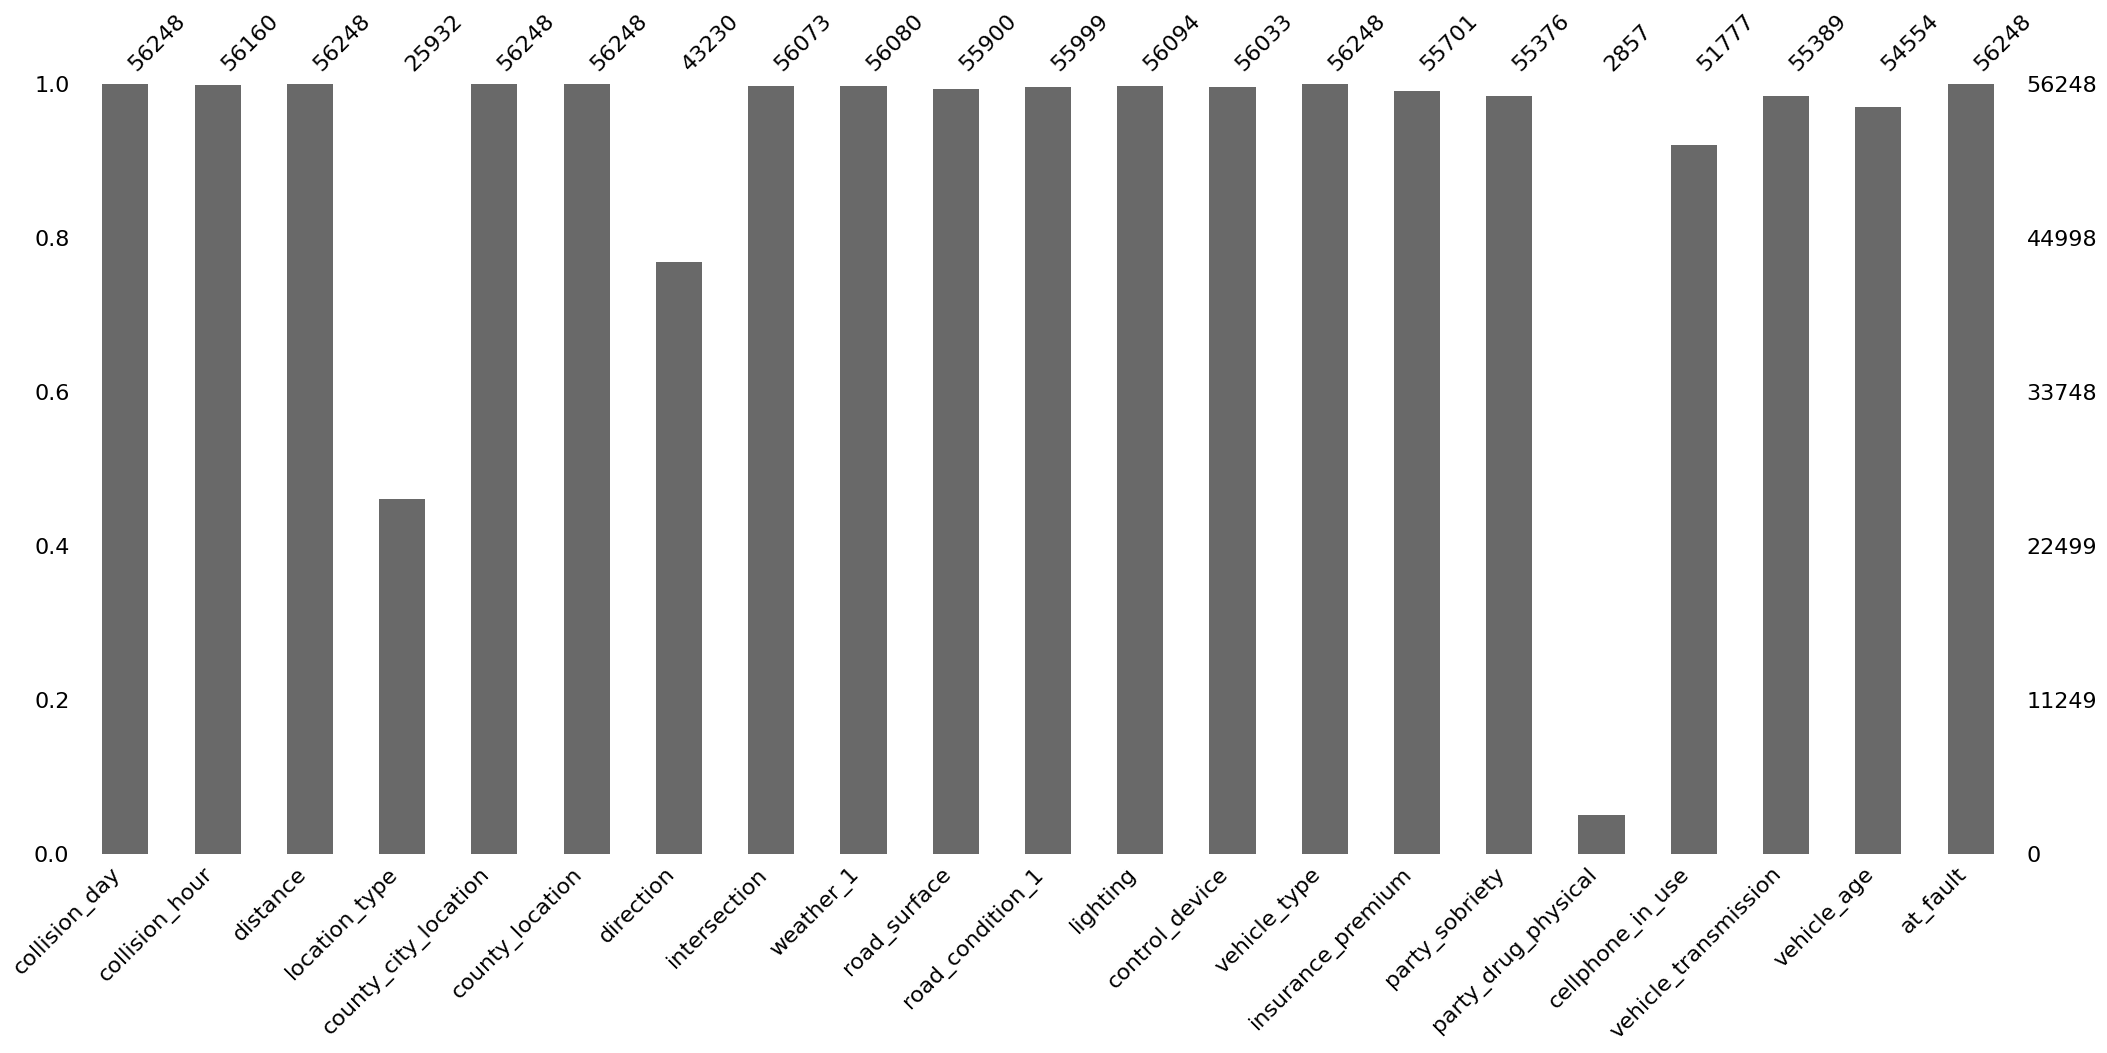

In [60]:
msno.bar(df);

Согласно отчету, в 14 столбцах отсутствуют значения. В большинстве столбцов пропущено менее 1% значений, за исключением vehicle_transmission (2%), party_drug_physical (89%), party_sobriety (2%), location_type (), direction ().

У нас много пропущенных значений в party_drug_physical, вероятно, это означает «нормальное состояние». Мы будем исползовать SimpleImputer для замены этых пропусков.

Что касается отсутствующих значений для 'location_type', нам нужно рассмотреть это более внимательно.

In [61]:
df['intersection'].value_counts()

intersection
0.0    43651
1.0    12422
Name: count, dtype: int64

In [62]:
df['location_type'].value_counts()

location_type
highway         21323
ramp             3267
intersection     1342
Name: count, dtype: int64

Мы видим, что некоторые из пропусков из «location_type» вероятно являются пересечениями, поскольку у нас их 12422.

In [63]:
len(df.query('intersection == 1 and location_type=="intersection"'))

1048

Мы видим, что некоторые перекрестки не упомянуты в «intersection», но упомянуты в «location_type».

In [64]:
list_inter_ano = df.query('intersection == 0 and location_type=="intersection"').index
list_inter_ano

Index([  251,   252,   280,   376,   377,   851,   972,  1203,  1439,  1758,
       ...
       53856, 53877, 54377, 54837, 55136, 55137, 55138, 55936, 56055, 56056],
      dtype='int64', length=292)

In [65]:
df.query('intersection == 0 and location_type!="intersection"').index

Index([    3,     7,     8,     9,    10,    13,    16,    17,    18,    21,
       ...
       56235, 56236, 56237, 56238, 56239, 56240, 56241, 56242, 56243, 56245],
      dtype='int64', length=43359)

In [66]:
list_intersection_index = df.query('intersection == 1').index
list_intersection_index

Index([    0,     1,     2,     4,     5,     6,    11,    12,    14,    15,
       ...
       56208, 56209, 56213, 56221, 56222, 56233, 56234, 56244, 56246, 56247],
      dtype='int64', length=12422)

In [67]:
df.loc[list_intersection_index, 'location_type'] = 'intersection'

In [68]:
df.loc[list_inter_ano, 'location_type'] = None

In [69]:
df.query('road_surface.isna()')['weather_1']

132       None
133       None
408       None
703       None
733      clear
         ...  
55655    clear
55898     None
55933    clear
55937    clear
55997    clear
Name: weather_1, Length: 348, dtype: object

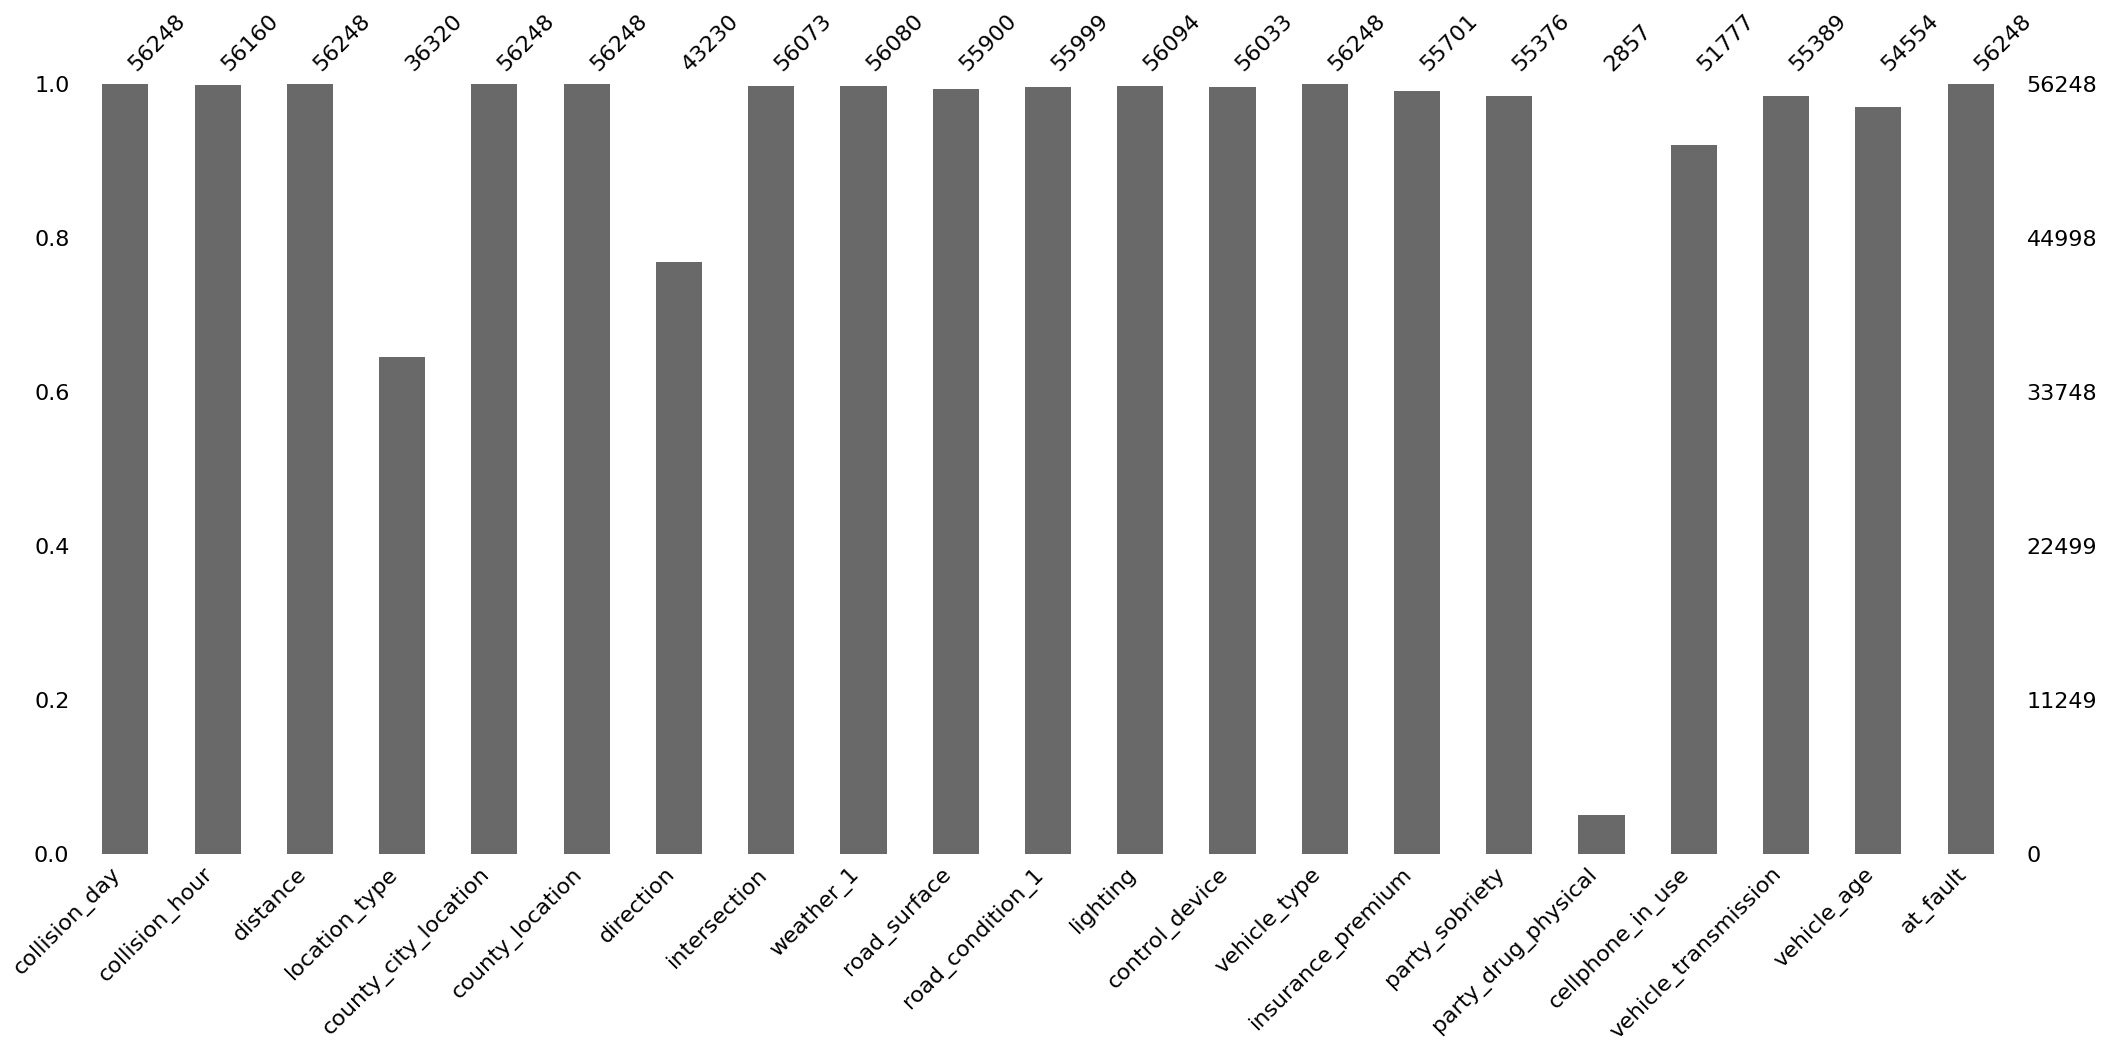

In [70]:
msno.bar(df);

Except for party_drug_physical we are going to use SimpleImputer with the strategy 'most frequent' to replace missing values.

In [71]:
df.query('location_type.isna()')

collision_day  collision_hour  distance location_type  \
3                3.0            19.0       5.0          None   
7                4.0             5.0      72.0          None   
9                0.0            19.0     444.0          None   
16               6.0            18.0     335.0          None   
17               6.0            18.0     335.0          None   
...              ...             ...       ...           ...   
56230            1.0            11.0     150.0          None   
56231            1.0            11.0     150.0          None   
56238            1.0            19.0      75.0          None   
56239            1.0            19.0      75.0          None   
56240            1.0            12.0     371.0          None   

      county_city_location county_location direction  intersection weather_1  \
3                     3607  san bernardino      east           0.0     clear   
7                     1942     los angeles      west           0.0     clear   
9                     3711       san diego     north           0.0     clear   
16                    3401      sacramento     north           0.0     clear   
17                    3401      sacramento     north           0.0     clear   
...                    ...             ...       ...           ...       ...   
56230                 0109         alameda     south           0.0     clear   
56231                 0109         alameda     south           0.0     clear   
56238                 3305       riverside      east           0.0     clear   
56239                 3305       riverside      east           0.0     clear   
56240                 5400          tulare     south           0.0     clear   

      road_surface  ...                    lighting control_device  \
3              dry  ...     dark with street lights    functioning   
7              dry  ...                dusk or dawn    functioning   
9              dry  ...  dark with no street lights           none   
16             dry  ...  dark with no street lights           none   
17             dry  ...  dark with no street lights           none   
...            ...  ...                         ...            ...   
56230          dry  ...                    daylight           none   
56231          dry  ...                    daylight           none   
56238          dry  ...                dusk or dawn           none   
56239          dry  ...                dusk or dawn           none   
56240          dry  ...                    daylight           none   

      vehicle_type insurance_premium         party_sobriety  \
3            sedan              31.0  had not been drinking   
7            sedan              52.0  had not been drinking   
9            coupe              63.0  had not been drinking   
16           sedan              21.0  had not been drinking   
17           coupe              37.0  had not been drinking   
...            ...               ...                    ...   
56230        coupe              57.0  had not been drinking   
56231        sedan              49.0  had not been drinking   
56238        sedan              19.0  had not been drinking   
56239        sedan              62.0  had not been drinking   
56240        sedan              19.0  had not been drinking   

        party_drug_physical cellphone_in_use  vehicle_transmission  \
3                      None              0.0                  auto   
7           sleepy/fatigued              0.0                  auto   
9                      None              0.0                manual   
16     under drug influence              0.0                manual   
17                     None              0.0                manual   
...                     ...              ...                   ...   
56230                  None              0.0                manual   
56231                  None              0.0                  auto   
56238                  None              0.0     

### Дубликаты

#### Явние дубликаты

In [72]:
# Проверка количества явных дубликатов
sum_dupli = df.duplicated().sum()
print(f'Есть {sum_dupli} дубликаты')

Есть 33 дубликаты


In [73]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
56243    False
56244    False
56245    False
56246    False
56247    False
Length: 56248, dtype: bool

In [74]:
df = df.drop_duplicates()

In [75]:
# Проверка если удаление сработало
sum_dupli = df.duplicated().sum()
print(f'Есть {sum_dupli} дубликаты')

Есть 0 дубликаты


#### Не явние дупликаты

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56215 entries, 0 to 56247
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   collision_day         56215 non-null  float64
 1   collision_hour        56127 non-null  float64
 2   distance              56215 non-null  float64
 3   location_type         36298 non-null  object 
 4   county_city_location  56215 non-null  object 
 5   county_location       56215 non-null  object 
 6   direction             43208 non-null  object 
 7   intersection          56040 non-null  float64
 8   weather_1             56047 non-null  object 
 9   road_surface          55867 non-null  object 
 10  road_condition_1      55966 non-null  object 
 11  lighting              56061 non-null  object 
 12  control_device        56000 non-null  object 
 13  vehicle_type          56215 non-null  object 
 14  insurance_premium     55669 non-null  float64
 15  party_sobriety        55

In [77]:
df.head()

collision_day  collision_hour  distance location_type county_city_location  \
0            5.0             7.0       0.0  intersection                 3712   
1            1.0            12.0       0.0  intersection                 3404   
2            2.0            16.0       0.0  intersection                 3400   
3            3.0            19.0       5.0          None                 3607   
4            6.0            13.0       0.0  intersection                 3400   

  county_location direction  intersection weather_1 road_surface  ...  \
0       san diego      None           1.0    cloudy          dry  ...   
1      sacramento      None           1.0     clear          dry  ...   
2      sacramento      None           1.0     clear          dry  ...   
3  san bernardino      east           0.0     clear          dry  ...   
4      sacramento      None           1.0     clear          dry  ...   

                  lighting control_device vehicle_type insurance_premium  \
0                 daylight           none        sedan              42.0   
1                 daylight           none        sedan              31.0   
2                 daylight    functioning        sedan              21.0   
3  dark with street lights    functioning        sedan              31.0   
4                 daylight    functioning        coupe              41.0   

          party_sobriety party_drug_physical cellphone_in_use  \
0  had not been drinking                None              0.0   
1  had not been drinking                None              0.0   
2  had not been drinking                None              0.0   
3  had not been drinking                None              0.0   
4  had not been drinking                None              0.0   

   vehicle_transmission vehicle_age  at_fault  
0                  auto         2.0         0  
1                  auto         5.0         0  
2                  auto         1.0         0  
3                  auto         4.0         0  
4                  auto         6.0         0  

[5 rows x 21 columns]

In [78]:
cat_col = df.drop(["county_location","county_city_location"], axis=1).select_dtypes(include='object')\
                                                                                            .columns.to_list()
cat_col

['location_type',
 'direction',
 'weather_1',
 'road_surface',
 'road_condition_1',
 'lighting',
 'control_device',
 'vehicle_type',
 'party_sobriety',
 'party_drug_physical',
 'vehicle_transmission']

In [79]:
for col in cat_col:
    print(f'For {col}')
    print(df[col].value_counts())

For location_type
location_type
highway         21111
intersection    12413
ramp             2774
Name: count, dtype: int64
For direction
direction
north    12123
south    11879
west      9700
east      9506
Name: count, dtype: int64
For weather_1
weather_1
clear      45064
cloudy      8422
raining     2178
fog          181
snowing      157
other         34
wind          11
Name: count, dtype: int64
For road_surface
road_surface
dry         50212
wet          5255
snowy         357
slippery       43
Name: count, dtype: int64
For road_condition_1
road_condition_1
normal            54034
construction       1002
obstruction         248
other               228
holes               222
loose material      128
reduced width        72
flooded              32
Name: count, dtype: int64
For lighting
lighting
daylight                                   38041
dark with street lights                    11010
dark with no street lights                  5107
dusk or dawn                                

Никаких неочевидных дублей мы не заметили. Однако мы замечаем, что в party_drug_physical у нас должно быть «нарушение неизвестно», но вместо этого у нас есть «G».

In [80]:
# Найдиом где значение 'G' появлаеться
index_g = df.query('party_drug_physical == "G"').index

In [81]:
# Замена значения «G» на «impairement_unknown» в 'party_drug_physical'
df.loc[index_g,'party_drug_physical'] = df.loc[index_g,'party_drug_physical']\
                                            .str.replace('G', 'impairement_unknown', regex=True)

In [82]:
# Удаление некоторых артефактов в наших значениях, которые могут беспокоить Shap
df = df.replace(',','', regex=True)
df = df.replace('\(','', regex=True)
df = df.replace('\)','', regex=True)

### Статистическое исследование

In [83]:
num_col= ['insurance_premium', 'vehicle_age', 'distance']
df[num_col].describe()

insurance_premium   vehicle_age      distance
count       55669.000000  54522.000000  5.621500e+04
mean           37.607681      4.856242  8.598114e+02
std            16.328926      3.234577  7.242398e+03
min             0.000000      0.000000  0.000000e+00
25%            24.000000      3.000000  7.000000e+00
50%            34.000000      4.000000  1.350000e+02
75%            49.000000      7.000000  5.450000e+02
max           105.000000    161.000000  1.584000e+06

Средняя страховая сумма составляет 43,77 тысячы долларов, но более половины водителей находятся ниже этого значения. 25% водителей платят большее 58 тысячы долларов на год за страховку. 

Средний возраст автомобиля, попавшего в дтп, составляет около 6 лет. 75% из них меньше или равны 9 годам. Это значит, что либо в автопарке не так много старых машин, либо не так уж много старых машин, попавших в дтп. Мы замечаем некоторые аномалии в признаке vehicle_age: автомобиля возрастом 161 год не существует.

### Ящик с усами

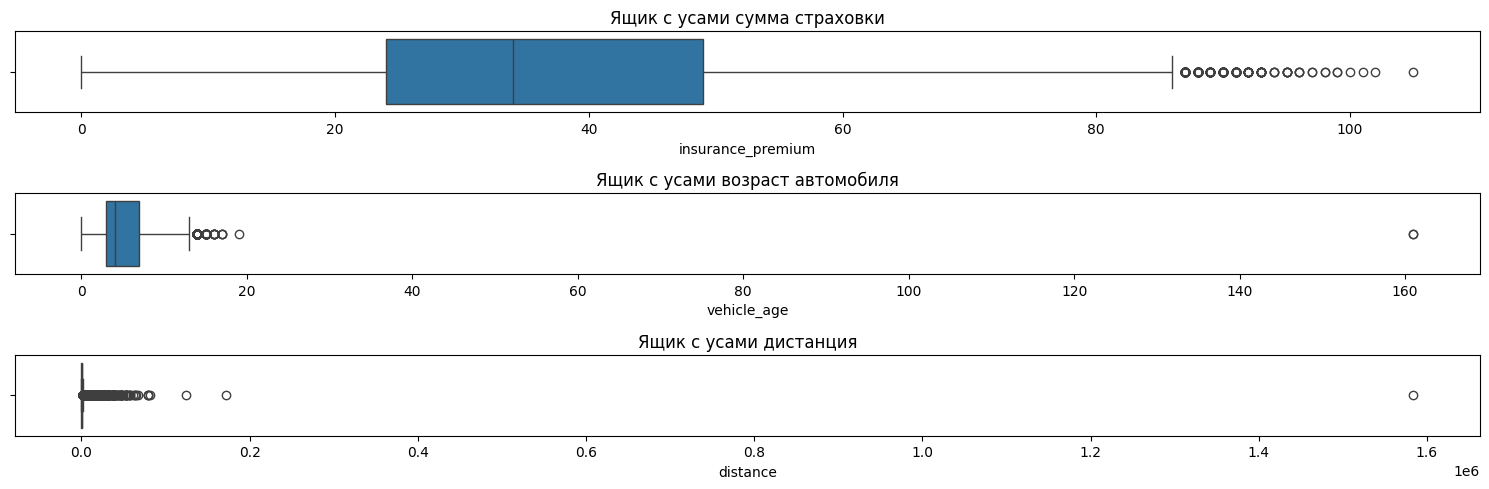

In [84]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 5))

axes = axes.flatten()

columns_names = ['сумма страховки', 'возраст автомобиля', 'дистанция']
for i, column in enumerate(df[num_col].columns):
    
    sns.boxplot(data=df, x=column, ax=axes[i]) 
    
    axes[i].set_title(f'Ящик с усами {columns_names[i]}') 

plt.tight_layout()


plt.show()

Мы замечаем выбросы в insurance_premium, distance и vehicle_age, но не собираемся от них избавляться. 
Однако мы видим некоторые аномалии. 
Мы удалим автомобили старше 10 лет, поскольку каршеринговая компания не будет использовать автомобили старше 10 лет.

In [85]:
df.query('vehicle_age > 10')

collision_day  collision_hour  distance location_type  \
15               4.0            11.0       0.0  intersection   
31               2.0            15.0       0.0  intersection   
33               3.0             6.0    1320.0       highway   
36               6.0            12.0       0.0  intersection   
73               4.0            17.0   22176.0       highway   
...              ...             ...       ...           ...   
56179            1.0            17.0     310.0          None   
56191            0.0            17.0     100.0       highway   
56217            0.0            20.0     105.0          None   
56227            1.0            11.0      10.0          None   
56245            2.0            23.0      25.0       highway   

      county_city_location county_location direction  intersection weather_1  \
15                    1942     los angeles      None           1.0     clear   
31                    3700       san diego      None           1.0     clear   
33                    3600  san bernardino      east           0.0     clear   
36                    3900     san joaquin      None           1.0     clear   
73                    3600  san bernardino     south           0.0     clear   
...                    ...             ...       ...           ...       ...   
56179                 0900       el dorado      west           0.0    cloudy   
56191                 1700            lake     north           0.0     clear   
56217                 1912     los angeles     north           0.0     clear   
56227                 0109         alameda      east           0.0     clear   
56245                 1942     los angeles     north           0.0     clear   

      road_surface  ...                    lighting control_device  \
15             dry  ...                    daylight    functioning   
31             dry  ...                    daylight    functioning   
33             dry  ...                dusk or dawn           none   
36             dry  ...                    daylight           none   
73             dry  ...  dark with no street lights           none   
...            ...  ...                         ...            ...   
56179          wet  ...                    daylight           none   
56191          dry  ...                    daylight           none   
56217          dry  ...     dark with street lights           none   
56227          dry  ...                    daylight    functioning   
56245          dry  ...     dark with street lights           none   

      vehicle_type insurance_premium                     party_sobriety  \
15           sedan              65.0              had not been drinking   
31           coupe              73.0              had not been drinking   
33           coupe              74.0              had not been drinking   
36           coupe              69.0              had not been drinking   
73           coupe              70.0              had not been drinking   
...            ...               ...                                ...   
56179        coupe              75.0              had not been drinking   
56191        coupe              68.0              had not been drinking   
56217        sedan              44.0  had been drinking under influence   
56227        coupe              71.0              had not been drinking   
56245        sedan              79.0              had not been drinking   

      party_drug_physical cellphone_in_use  vehicle_transmission vehicle_age  \
15                   None              0.0                manual        11.0   
31                   None              0.0                manual        11.0   
33                   None              NaN                manual        11.0   
36                   None              0.0                  auto        11.0   
73                   None              0.0                manual        11.0   
...                   ...              ...             

In [86]:
index_ano_v_age = df.query('vehicle_age > 10').index
index_ano_v_age

Index([   15,    31,    33,    36,    73,    76,    89,    98,   108,   117,
       ...
       56138, 56147, 56173, 56176, 56178, 56179, 56191, 56217, 56227, 56245],
      dtype='int64', length=3139)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56215 entries, 0 to 56247
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   collision_day         56215 non-null  float64
 1   collision_hour        56127 non-null  float64
 2   distance              56215 non-null  float64
 3   location_type         36298 non-null  object 
 4   county_city_location  56215 non-null  object 
 5   county_location       56215 non-null  object 
 6   direction             43208 non-null  object 
 7   intersection          56040 non-null  float64
 8   weather_1             56047 non-null  object 
 9   road_surface          55867 non-null  object 
 10  road_condition_1      55966 non-null  object 
 11  lighting              56061 non-null  object 
 12  control_device        56000 non-null  object 
 13  vehicle_type          56215 non-null  object 
 14  insurance_premium     55669 non-null  float64
 15  party_sobriety        55

In [88]:
df.drop(index_ano_v_age, axis=0, inplace=True)

In [89]:
# Аномали про расстоянии
df.query('distance > 200000')

collision_day  collision_hour   distance location_type  \
55609            2.0            15.0  1584000.0       highway   

      county_city_location county_location direction  intersection weather_1  \
55609                 1942     los angeles     north           0.0     clear   

      road_surface  ...  lighting control_device vehicle_type  \
55609          dry  ...  daylight           none        sedan   

      insurance_premium         party_sobriety party_drug_physical  \
55609              22.0  had not been drinking                None   

      cellphone_in_use  vehicle_transmission vehicle_age  at_fault  
55609              0.0                manual         3.0         1  

[1 rows x 21 columns]

Это расстояние выглядит неправильным. Вероятно, 1584.

In [90]:
df.loc[55609, 'distance'] = 1584

In [91]:
# Проверяем, что мы удалили только 6 объектов
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53076 entries, 0 to 56247
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   collision_day         53076 non-null  float64
 1   collision_hour        52992 non-null  float64
 2   distance              53076 non-null  float64
 3   location_type         34234 non-null  object 
 4   county_city_location  53076 non-null  object 
 5   county_location       53076 non-null  object 
 6   direction             40978 non-null  object 
 7   intersection          52912 non-null  float64
 8   weather_1             52918 non-null  object 
 9   road_surface          52751 non-null  object 
 10  road_condition_1      52842 non-null  object 
 11  lighting              52928 non-null  object 
 12  control_device        52877 non-null  object 
 13  vehicle_type          53076 non-null  object 
 14  insurance_premium     52538 non-null  float64
 15  party_sobriety        52

### Исследовательского анализа

In [92]:
# Создание отчета с помощью Sweetviz
feature_config = sv.FeatureConfig(force_cat = ['county_city_location'])
my_report = sv.analyze(df, target_feat='at_fault', feat_cfg = feature_config)

                                             |      | [  0%]   00:00 -> (? left)


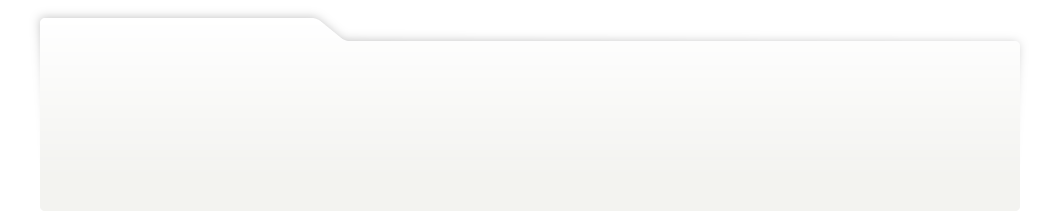
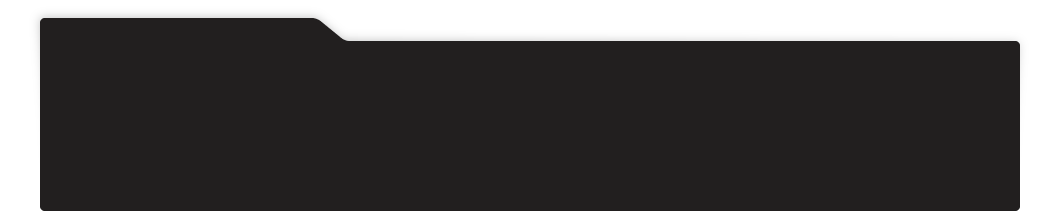
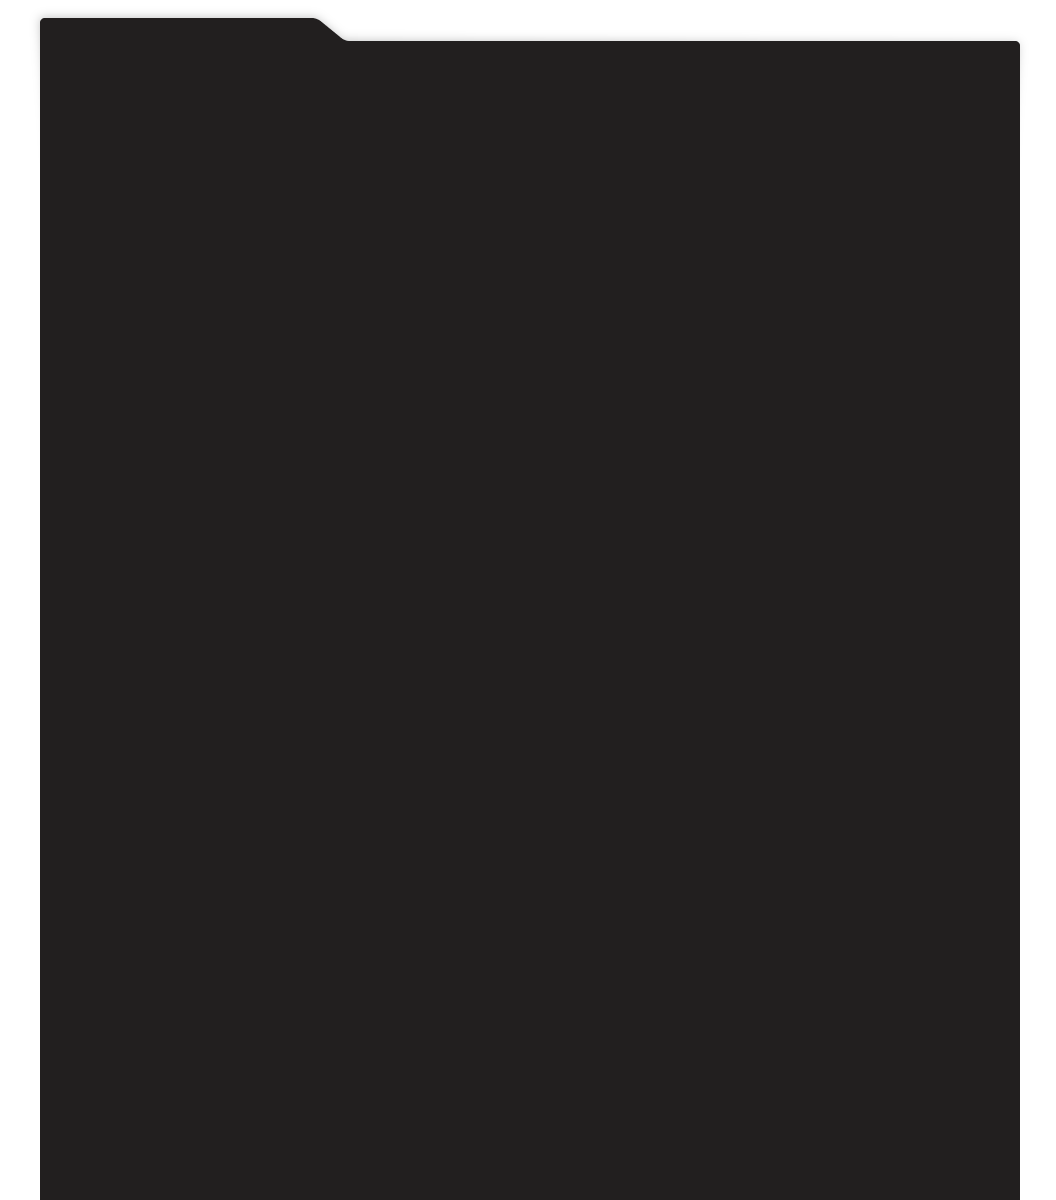
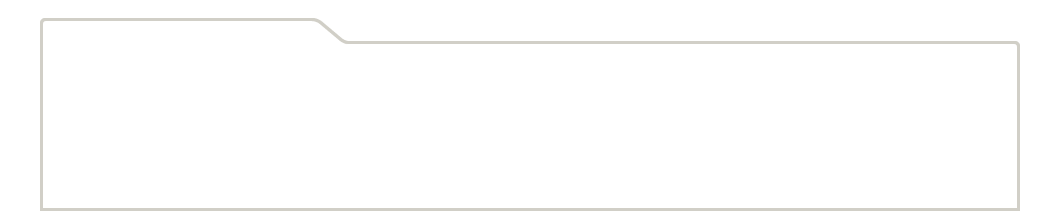
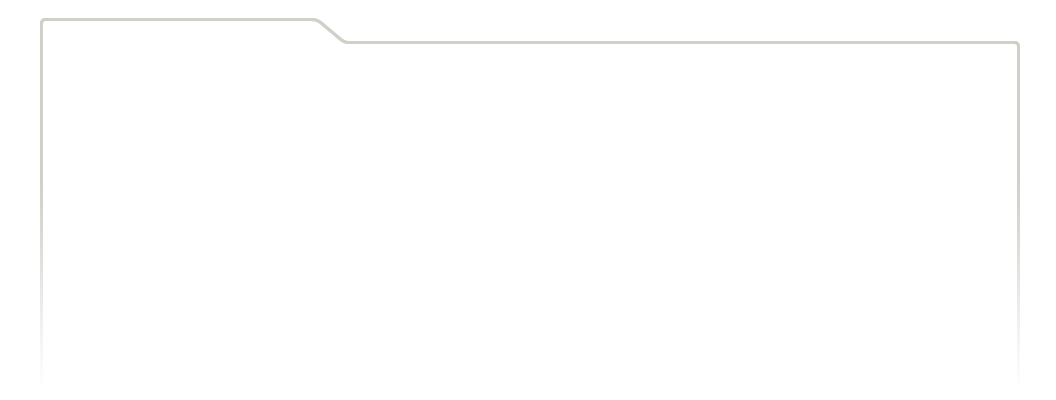
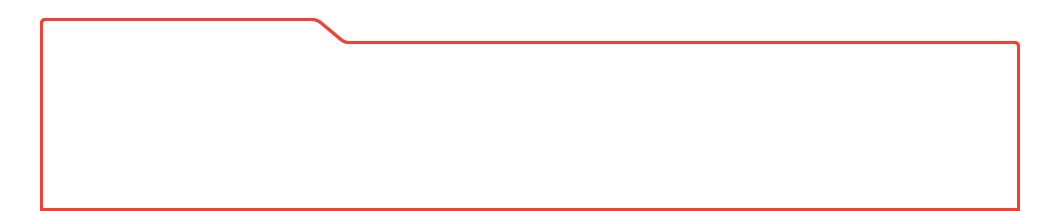
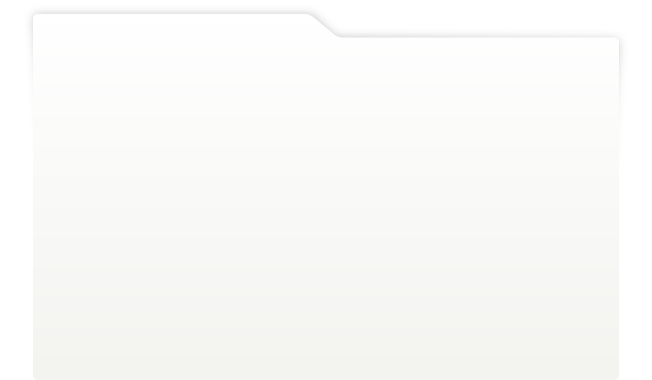
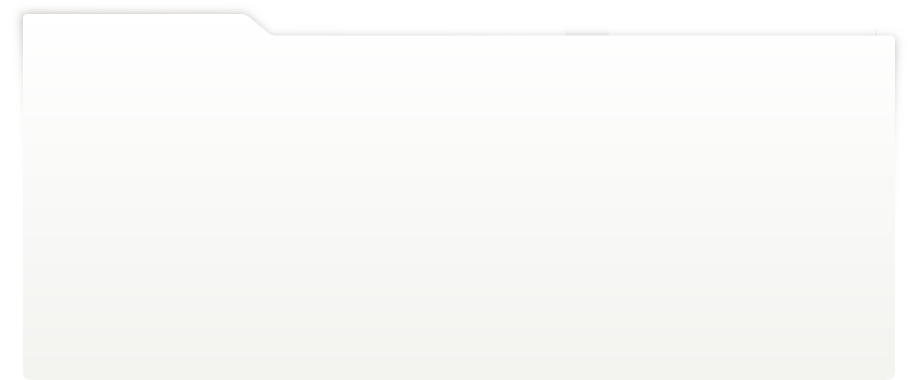
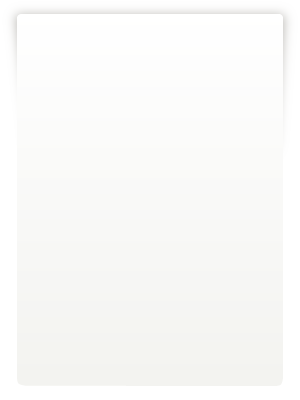
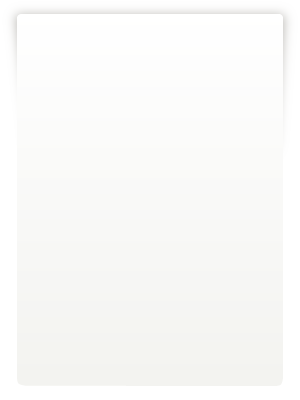
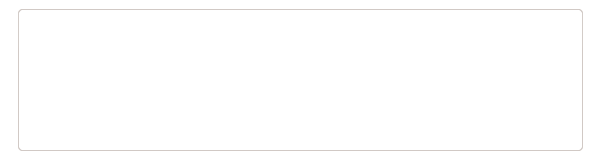
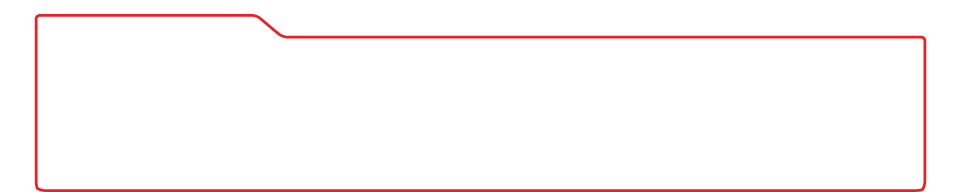
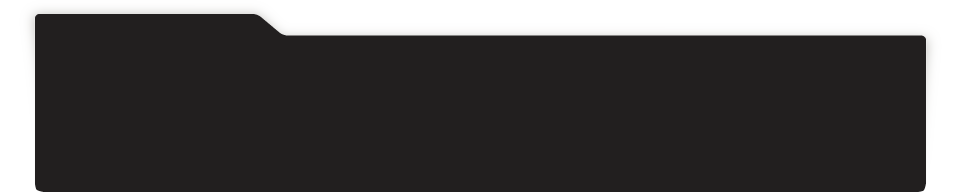
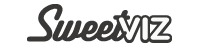
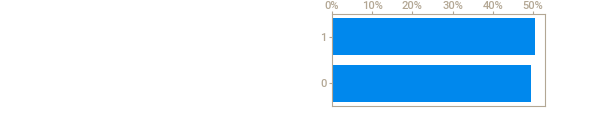
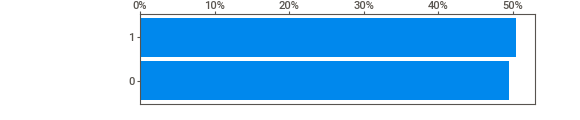
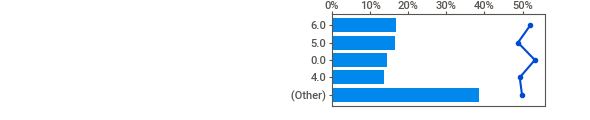
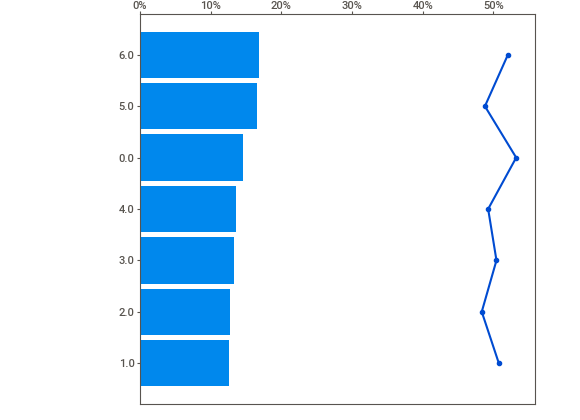
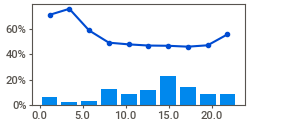
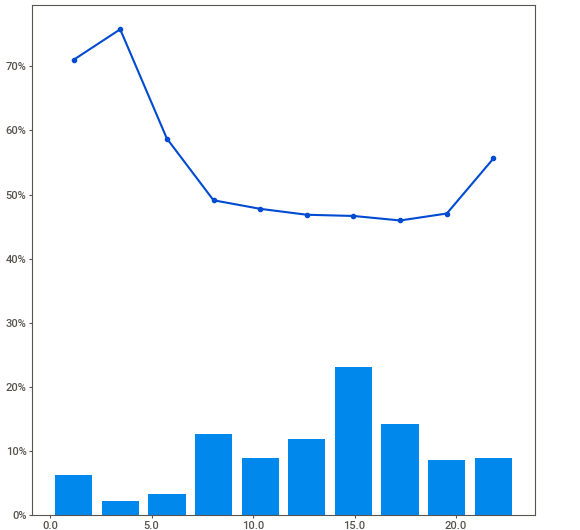
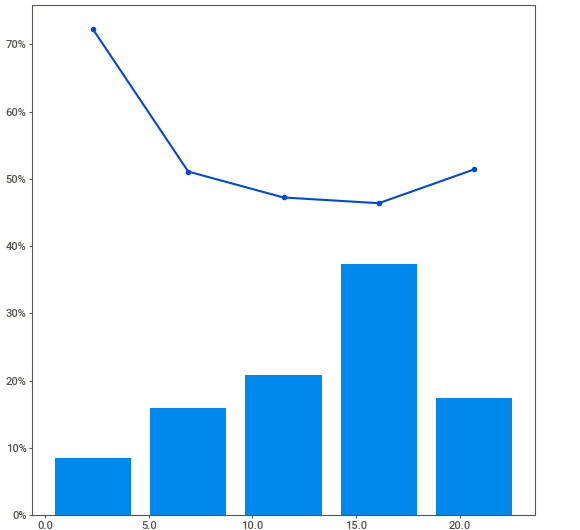
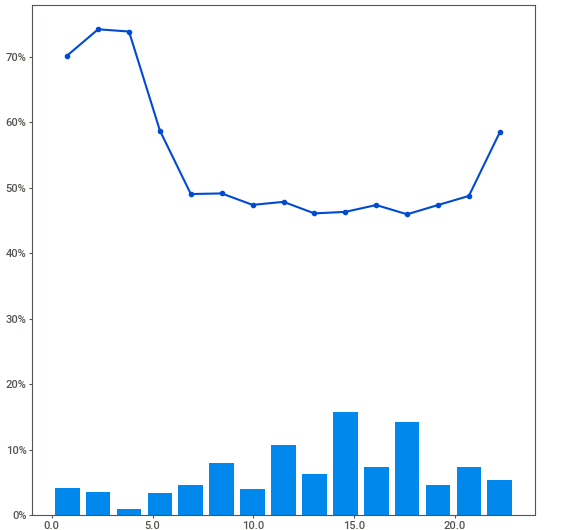
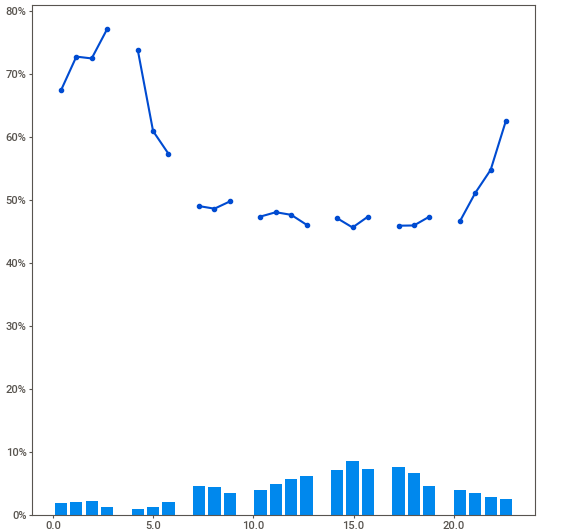
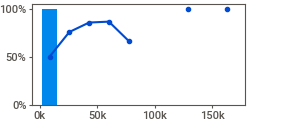
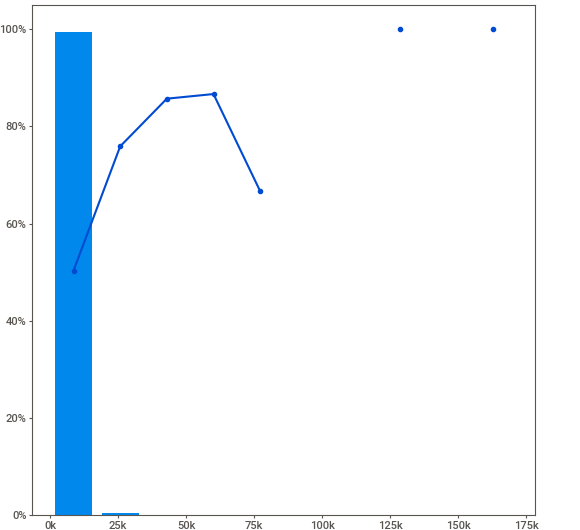
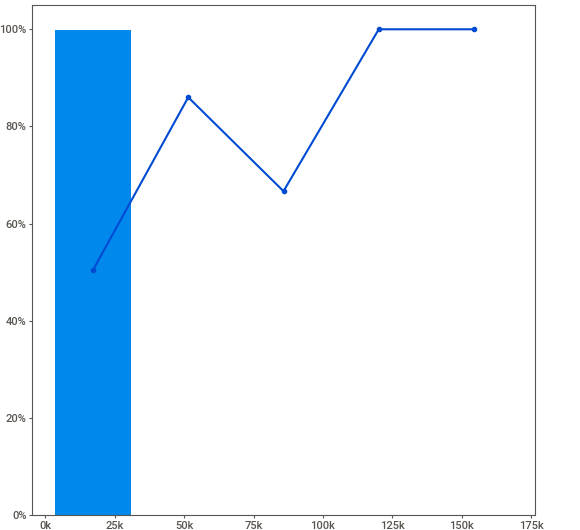
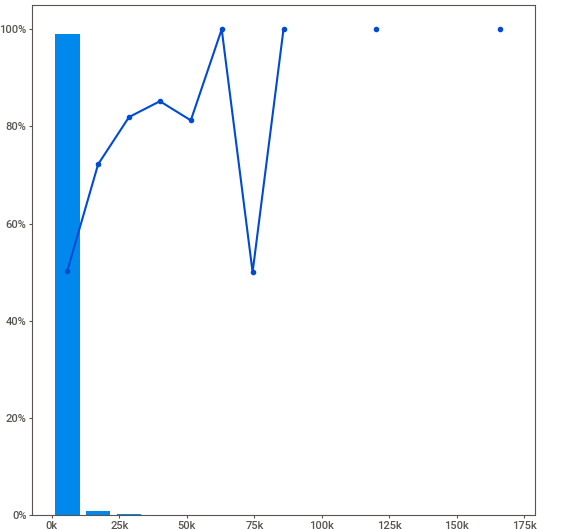
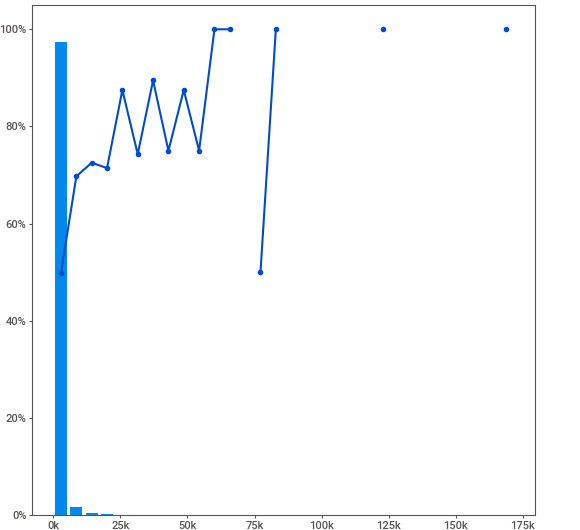
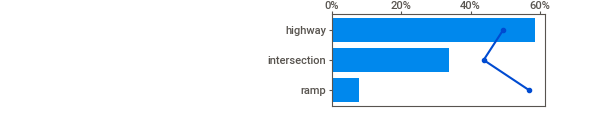
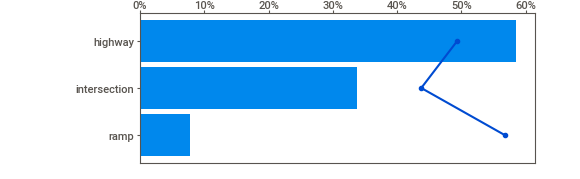
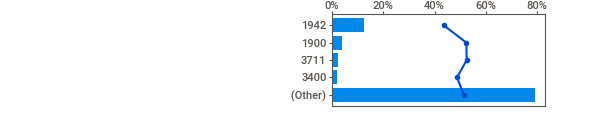
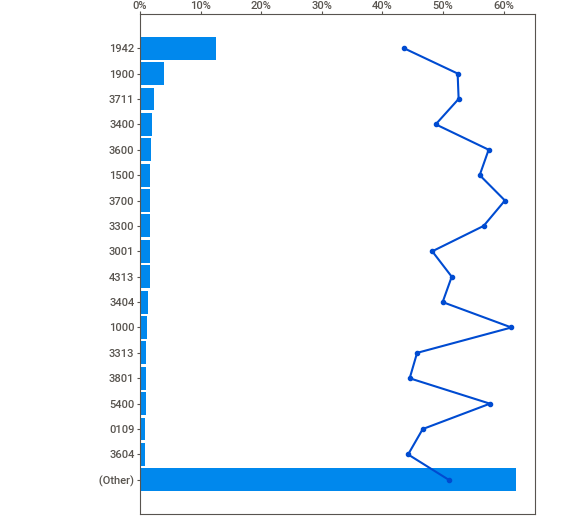
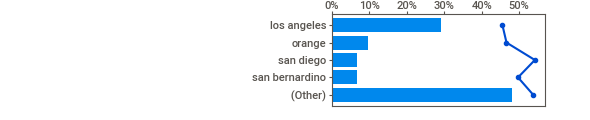
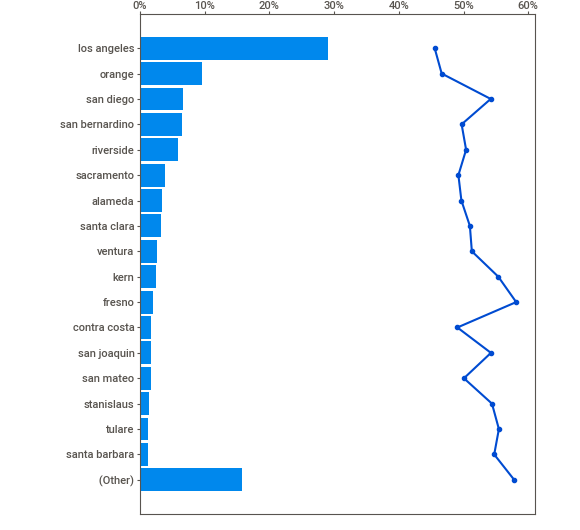
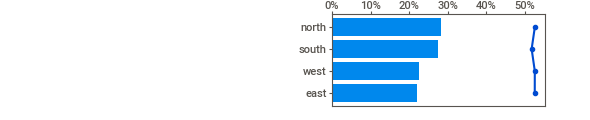
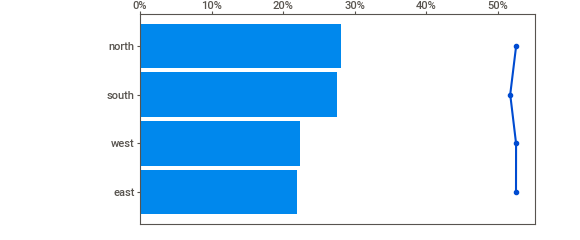
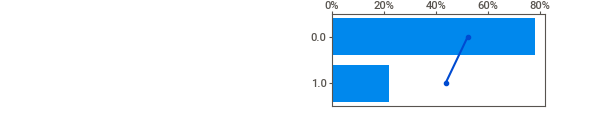
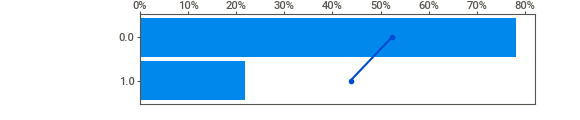
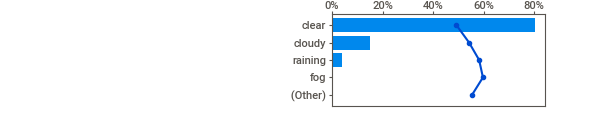
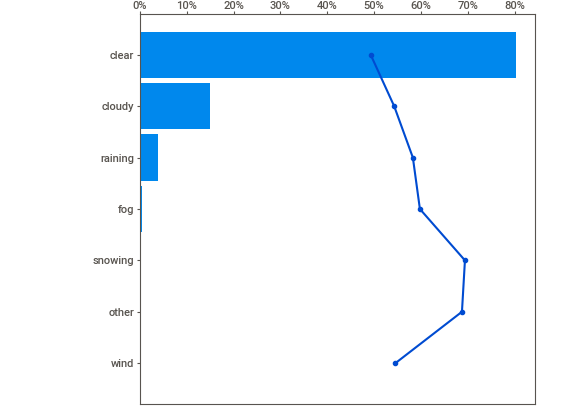
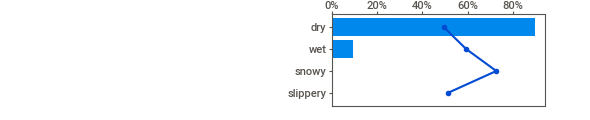
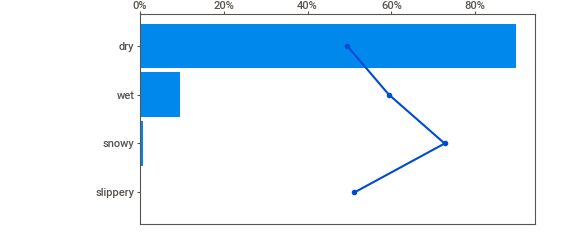
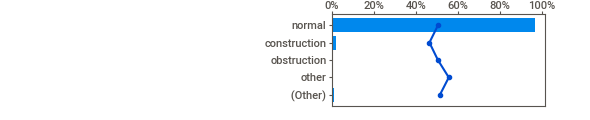
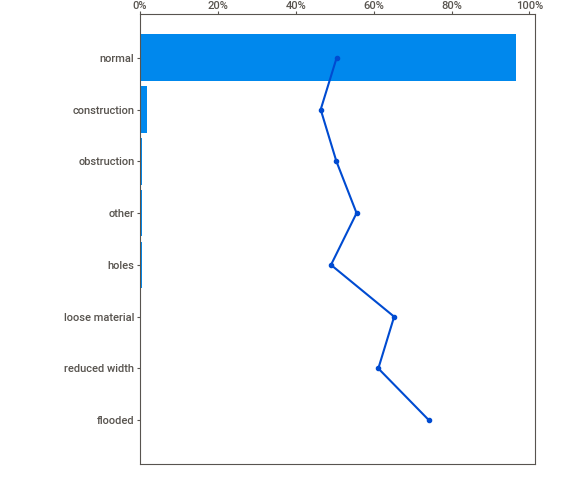
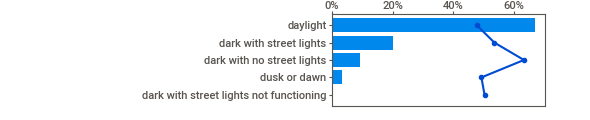
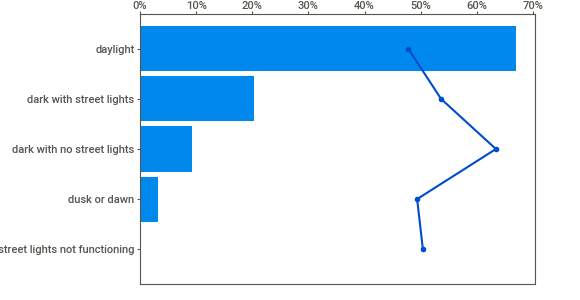
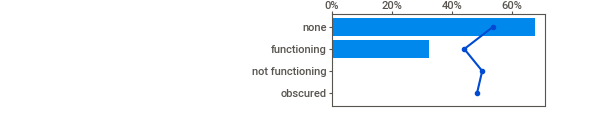
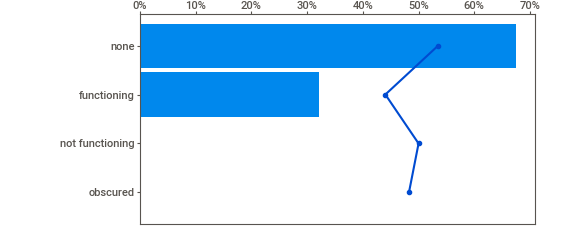
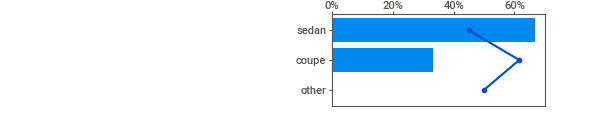
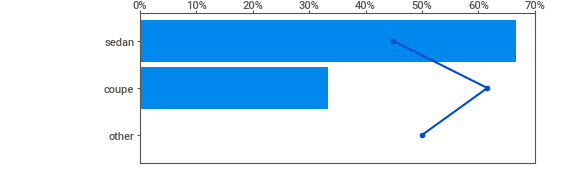
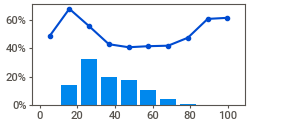
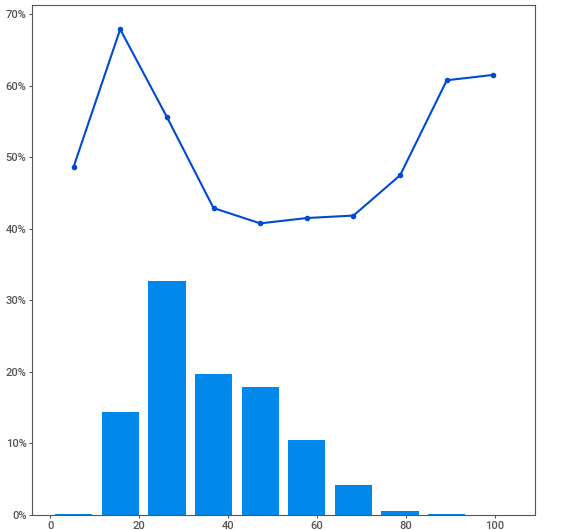
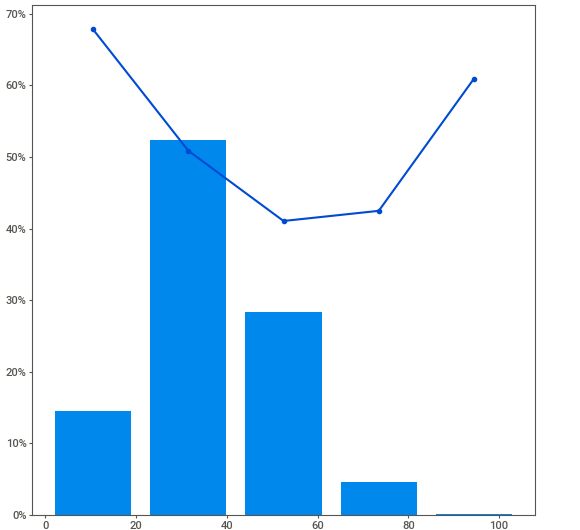
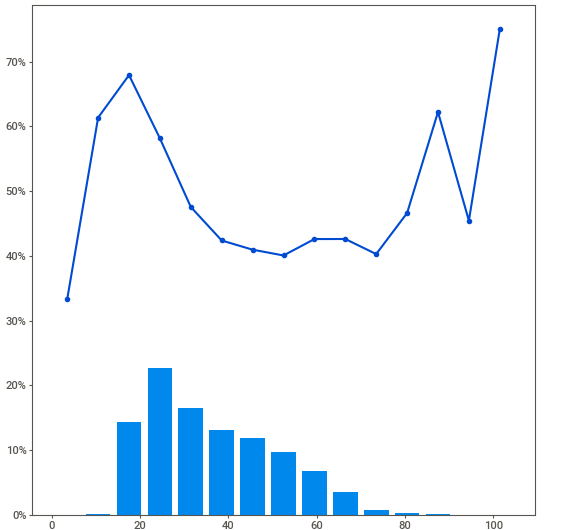
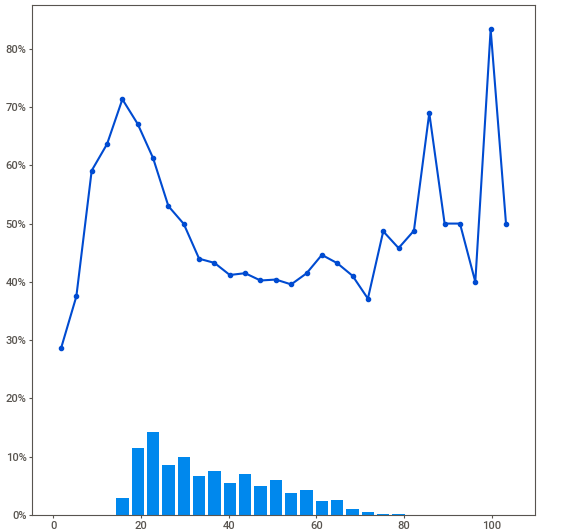
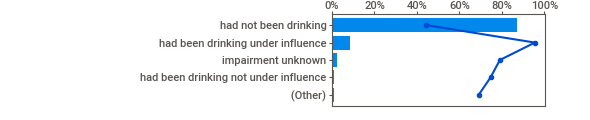
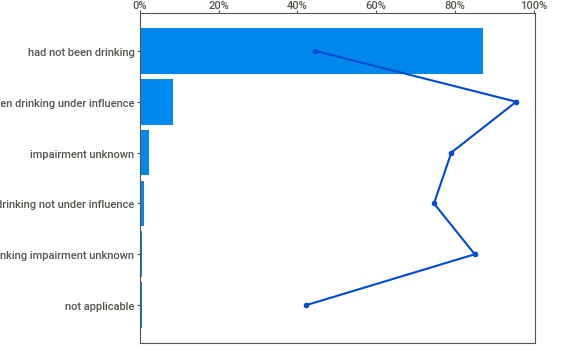
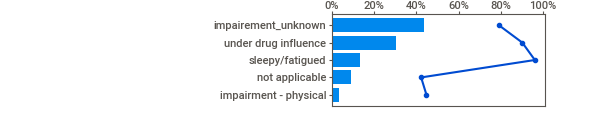
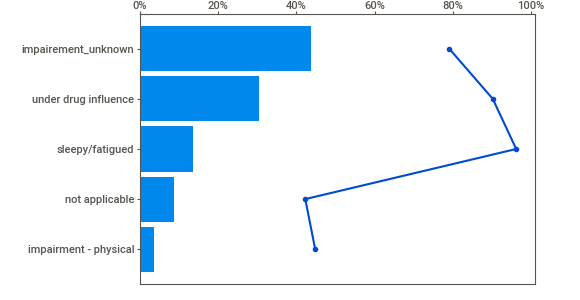
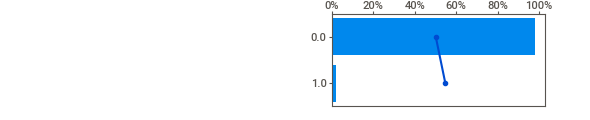
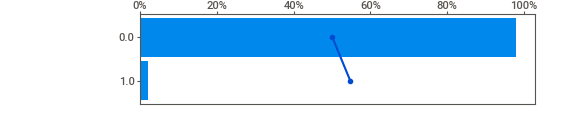
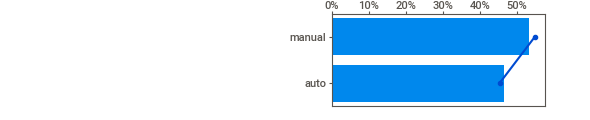
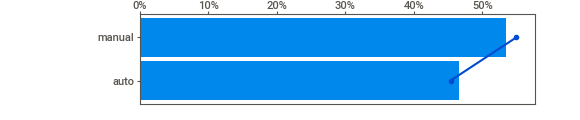
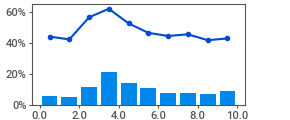
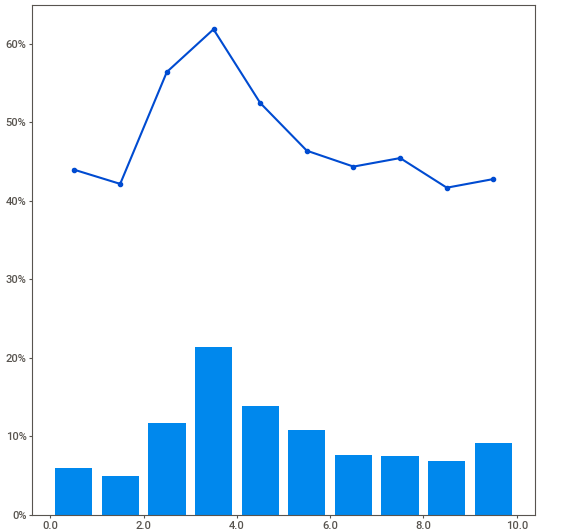
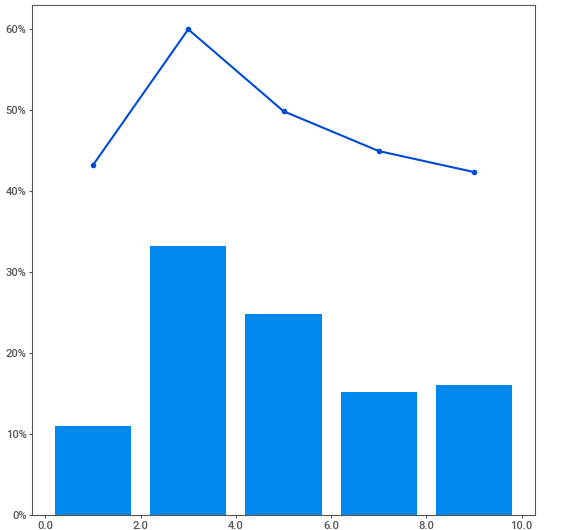
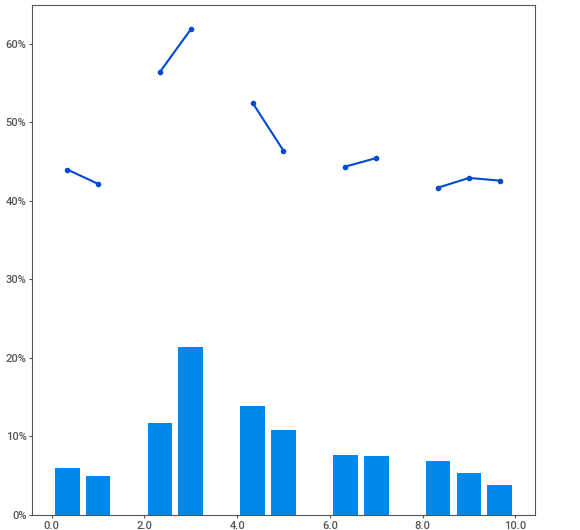
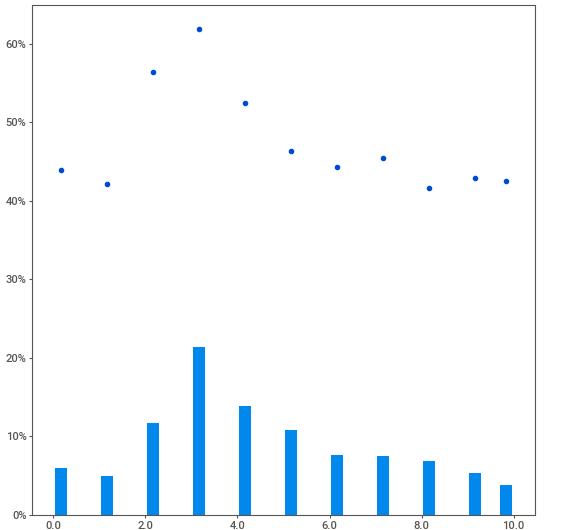
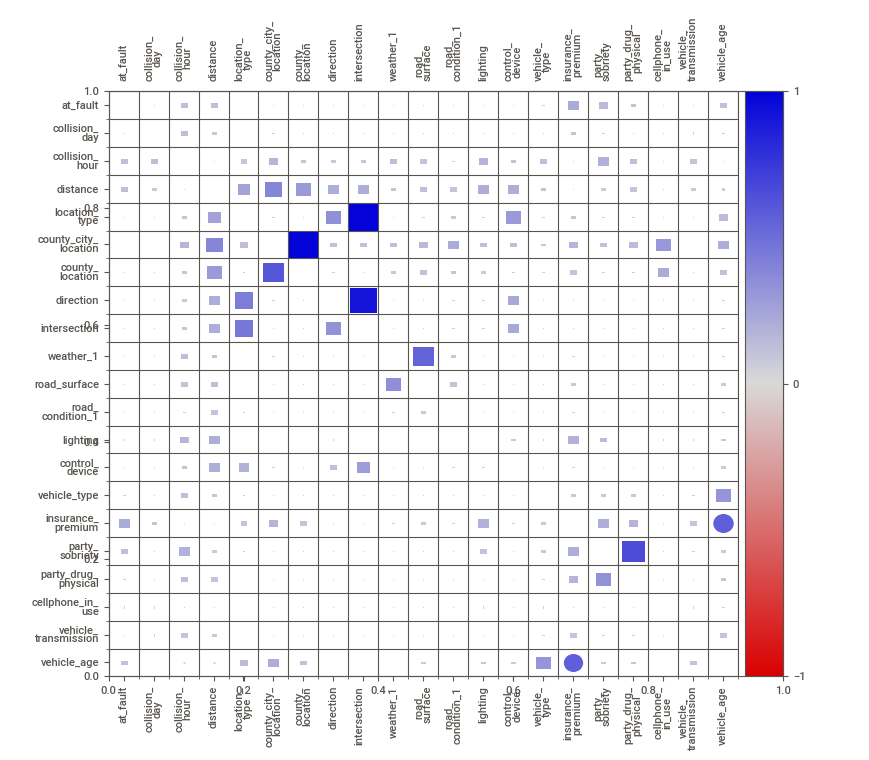
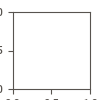

In [93]:
my_report.show_notebook()

<b>at_fault</b> : Это наша целевая переменная: 58% объектов относятся к младшему классу, а 42% объектов — к старшему классу. Есть маленький дисбаланс.

<b>county_location</b> : Мы видим, что в Los-Angeles ДТП больше, потому что это место более населено. Однако мы видим, что на наш целовой перемен больше всего влияет Fresno.

<b>county_city_location</b> : Мы видим, что в номер 1942 ДТП больше, этот код, вероятно, относится к городу в Калифорнии. 

<b>direction</b> : У нас больше ДТП в северном и южном направлении. Мы также видим, что этот признак не сильно влияет на нашу целовой признак.

<b>collision_day</b> : Большинство ДТП произошло в выходные дни в пятницу (конечно ночь) и субботу. Число несчастных случаев в воскресенье является третьим по величине, однако мы видим, что дни в зависимости от цели зависят от этого дня. В воскресенье в целом ДТП меньше, потому что многие люди остаются дома, однако многие из этих несчастных случаев происходят из-за дорожного происшествия, например, как мы видели ранее в предыдущей части.

<b>collision_time</b> : На графике мы видим, что большая часть ДТП происходит в полдень. Однако мы видим, что наша целевая переменная очень зависит от ранних временни (morning_night), что, безусловно, представляет собой ДТП для 'dui' ночью в выходные дни.

<b>weather_1</b> : Мы видим, что большая часть ДТП происходит при ясном небе, однако мы видим, что снег является наиболее влиятельной погодой на наш целовой признак.

<b>insurance_premium</b>:Средняя стоимость страховки составляет около 44 тысяч долларов в год, а большая часть ДТП происходит по страховке около 30, что намного ниже среднего показателя. Чтобы получить такую цену, водитель, вероятно, не молод, имеет стаж и хороший водительский стаж. Большинство виновных водителей - это водители с низкой стоимостью страховки (вероятно, пожилые люди с хорошим опытом и хорошим водительским стажем) и высокой ценой (молодой водитель, не очень опытный, или водитель с плохим водительским стажем, поэтому более склонный к ДТП).

<b>party_sobriety</b>: В большинстве ДТП виновны водители, которые не пили. Большинство виновных водителей - это водители, которые были пьяны или не проявляли нарушений.

<b>party_drug_physical</b>: В большинстве ДТП участвуют водители, находящиеся в нормальном состоянии. Большинство виновных водителей имели неизвестные нарушения функций, находились под воздействием наркотиков или устали.

<b>vehicle_type</b>: Большинство ДТП произошло с седаном, но большинство виновных водителей управляли транспортными средствами другого типа.

<b>vehicle_transmission</b>: ДТП с автомобилем с механической коробкой передач немного больше – 52% против 48% – с автомобилем с автоматической коробкой передач. Передача оказывает небольшое влияние на целовой перемене.

<b>vehicle_age</b>: Большинство автомобилей, попавших в ДТП, имеют возраст менее 5 лет. Мы видим, что влияние этой признаком на целовой признак увеличилось для более старых авто.

## Корреляционный анализ

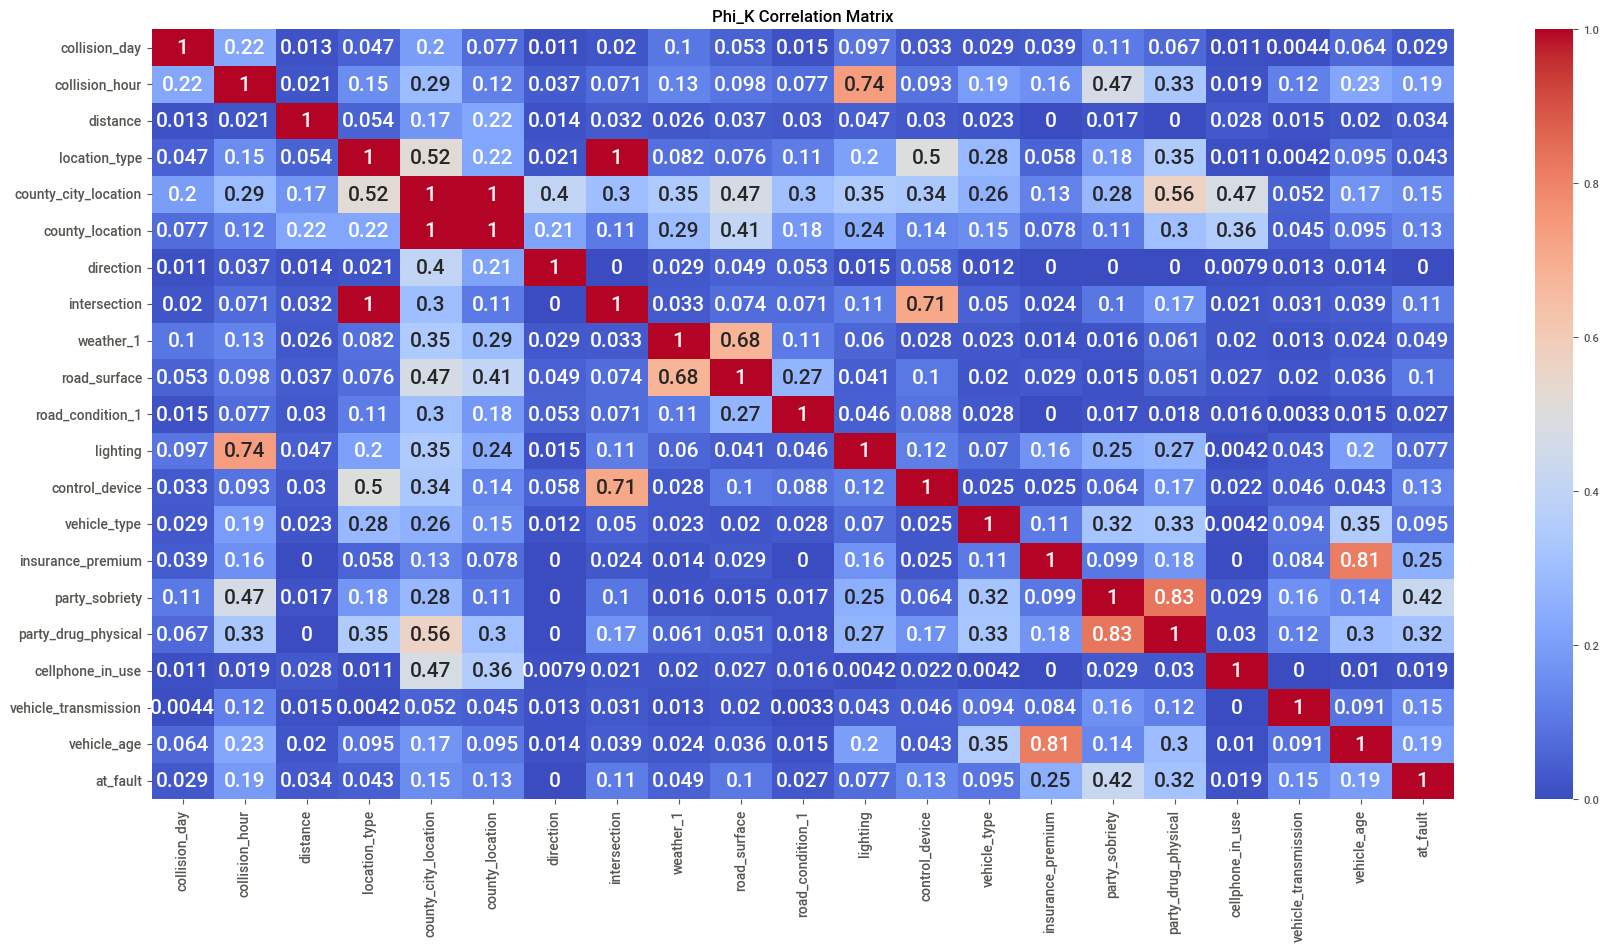

In [94]:
# Выбираем столбцы с числовым значением

interval_cols = ['insurance_premium', 'vehicle_age', 'distance']
# cols_name = ['местоположение', 'столкновение_день', 'период_времени', 'погода', 
#              'тип_авто', 'сумма страховки', 'участник_трезвость', 
#              'участник_наркотик_физическое_состояние', 'трансмиссия_авто', 'возраст_авто', 'виноват' ]

# Вычисляем матрицу корреляции с использованием phik
corr_matrix = df.phik_matrix(interval_cols=interval_cols)#.sample(frac=0.1, random_state=42)

# Визуализация матрицы 
plt.figure(figsize=(21, 10))
sns.heatmap(corr_matrix, 
#             xticklabels=cols_name,
#             yticklabels=cols_name,
            annot=True,
            annot_kws={"size":15},
            cmap='coolwarm');
plt.title('Phi_K Correlation Matrix')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10) 
plt.show()

In [95]:
len(df['county_city_location'].value_counts())

496

In [96]:
# Признаки который нужно удалять
f_to_remove = corr_matrix.query('at_fault == 0').index.to_list()
f_to_remove

['direction']

In [97]:
# Признаки который нужно удалять
f_col_to_remove = ['county_city_location', 'intersection']

Наиболее влиятельными признаками на целовой признак являются:
- party_sobriety
- party_drug_physical
- insurance_premium
- time_period
- vehicle_age
- vehicle_transmission
- county_location

Самы невлиятельными :
- vehicle_type
- weather
- day


Мы собираемся использовать все эти признаки для нашей модели.

In [98]:
df = df.drop(f_to_remove + f_col_to_remove, axis=1)

### Вывод 

Из EDA и корреляционной матрицы мы видим, что наши наиболее важные признаки: 
- party_sobriety
- party_drug_physical

которые дают нам информацию о состоянии драйвера. 

Потом наиболее важный признак - сумма страхови. Этот признак может дать нам некоторую информацию о характеристиках водителя, таких как его возраст и послужной список. Действительно, поскольку у молодых водителей, как правило, больше ДТП, из-за меньшего опыта вождения и, возможно, меньшей зрелости и мудрости, чем у старшего водителя, их страховка дороже. То же самое касается водителя с водителем с плохим водительским стажем. После более молодого водителя самым рискованным водителем является водитель старше 60 лет. Их страховка может быть дешевле, но они могут быть виноваты из-за большей невнимательности или меньшей реакции. Однако мы видели ранне что многих дтп за вождение под воздействием происходил когда у человека была сумма страховка не так высокая. Это означает что водитель был достаточно опытным.

По сравнению с другими характеристиками возраст автомобиля оказывает некоторое влияние на целовой. Действительно, новая машина может ехать быстрее, чем старая, вообще говоря, и они в лучшем состоянии, поэтому водитель может водить машину с меньшей осторожностью и немного быстрее. Действительно, если у вас есть старая машина, вы, вероятно, будете ездить с большей осторожностью, чтобы не сломать ее.

После этих признаков наименее важными являются vehicle_type и vehicle_transmission. Действительно, если у вас купе, вы можете ехать быстрее, и это может увеличить риск ДТП. По поводу трансмиссии автомобиля сказали, что с автоматической коробкой передач легче управлять, чем с механической, и можно более внимательно следить за тем, что происходит на дороге.

# Обучении

## Модели для обучении

Чтобы найти лучшую модель, мы будем использовать алгоритм RandomizedSearchCV с набором из 4 разных моделей
   - LGBMClassifier
   - LogisticRegression
   - KNeighborsClassifier
   - RandomForestClassifier
    
В качестве метрики мы будем использовать «ROC AUC».

## Проверка дубликатов

In [99]:
# Проверка количества явных дубликатов
sum_dupli = df.duplicated().sum()
print(f'Есть {sum_dupli} дубликаты')

Есть 23 дубликаты


In [100]:
# Удаление дубликаты
df = df.drop_duplicates()

In [101]:
# Проверка если удаление сработало
sum_dupli = df.duplicated().sum()
print(f'Есть {sum_dupli} дубликаты')

Есть 0 дубликаты


## Разделение данных в наборе обучающих и тестовых данных

In [102]:
# Подготовим наш целевой признак к моделированию
X = df.drop(['at_fault'], axis=1)

y = df['at_fault']

RANDOM_STATE = 42
TEST_SIZE = 0.25

# Разделение на треннировчной и тестовой
X_train, X_test, y_train, y_test = train_test_split(
                                    X,
                                    y,
                                    random_state=RANDOM_STATE,
                                    test_size=TEST_SIZE,
                                    stratify=y)

## Первая кросс-валидация

In [103]:
# Категоряльные значение
cat_columns_1 = ['county_location', 'weather_1', 'road_surface', 'road_condition_1', 'lighting', 'location_type',
                 'control_device', 'vehicle_type', 'party_sobriety', 'cellphone_in_use', 'vehicle_transmission']
cat_columns_2 = ['party_drug_physical']


# Количетьвеное значение
num_columns_1 = ['insurance_premium', 'vehicle_age', 'collision_day', 'collision_hour', 'distance']

ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# создаём пайплайн для категорильного значения
cat_pipe_1 = Pipeline([
    ('imp_1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('enc', ohe)
])

cat_pipe_2 = Pipeline([
    ('imp_2', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='normal_condition')),
    ('enc', ohe)
])

num_pipe_1 = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('scal', MinMaxScaler())
])


# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('cat_1', cat_pipe_1, cat_columns_1),
     ('cat_2', cat_pipe_2, cat_columns_2),
     ('num', num_pipe_1, num_columns_1)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', [lgb.LGBMClassifier(random_state=RANDOM_STATE)])
])

param_grid = [
    # словарь для модели LGBMClassifier()
   {
        'models': [lgb.LGBMClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [200],
        'models__learning_rate': [1e-3, 0.1],
        'models__num_leaves': [2, 2**10],
        'models__max_depth':[3,12, 25],
        'models__min_data_in_leaf': [1, 100]
    },
      # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__solver' : ['liblinear', 'saga'],
        'models__C': [0.001, 0.01, 0.1],
        'models__penalty': ['l1', 'l2']
     },
           # словарь для модели RandomForestClassifier()
     {
         'models':[RandomForestClassifier(random_state=RANDOM_STATE)],
         'models__n_estimators': [ 48, 56],
         'models__max_features': [2,14],
         'models__min_samples_split':[2,14],
         'models__min_samples_leaf':[2,14],
         'models__max_depth': [2,14,25]     
        }
]

In [104]:
randomized_search = RandomizedSearchCV(
        pipe,
        param_grid,
        cv=5,
        scoring='roc_auc',
        random_state=RANDOM_STATE,
        error_score="raise",
        n_jobs=-1
)
randomized_search.fit(X_train, y_train)

/home/regis/anaconda3/envs/gpu_env_torch/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/regis/anaconda3/envs/gpu_env_torch/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/regis/anaconda3/envs/gpu_env_torch/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/regis/anaconda3/envs/gpu_env_torch/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/regis/anaconda3/envs/gpu_env_torch/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X d

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat_1',
                                                                               Pipeline(steps=[('imp_1',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('enc',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['county_location',
                                                                                'weather_1',
                                                                                'road_surface',
                                                                                'road...
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': [0.001, 0.01, 0.1],
                                         'models__penalty': ['l1', 'l2'],
                                         'models__solver': ['liblinear',
                                                            'saga']},
                                        {'models': [RandomForestClassifier(random_state=42)],
                                         'models__max_depth': [2, 14, 25],
                                         'models__max_features': [2, 14],
                                         'models__min_samples_leaf': [2, 14],
                                         'models__min_samples_split': [2, 14],
                                         'models__n_estimators': [48, 56]}],
                   random_state=42, scoring='roc_auc')

## Самая лучая модел после кросс-валидаций 

In [105]:
# Итог гиперпараметр тюнинг
report_randomised_search = pd.DataFrame(randomized_search.cv_results_)
pd.set_option('display.max_colwidth', None)
report_randomised_search\
.sort_values('rank_test_score', ascending=True)[['param_models', 'params',\
                                                 'mean_fit_time', 'mean_score_time',\
                                                 'mean_test_score', 'rank_test_score']].head(10)

param_models  \
9  RandomForestClassifier(random_state=42)   
3          LGBMClassifier(random_state=42)   
7          LGBMClassifier(random_state=42)   
4          LGBMClassifier(random_state=42)   
5  RandomForestClassifier(random_state=42)   
0  RandomForestClassifier(random_state=42)   
2  RandomForestClassifier(random_state=42)   
1          LGBMClassifier(random_state=42)   
6          LGBMClassifier(random_state=42)   
8          LGBMClassifier(random_state=42)   

                                                                                                                                                                                                 params  \
9  {'models__n_estimators': 56, 'models__min_samples_split': 2, 'models__min_samples_leaf': 14, 'models__max_features': 14, 'models__max_depth': 14, 'models': RandomForestClassifier(random_state=42)}   
3             {'models__num_leaves': 2, 'models__n_estimators': 200, 'models__min_data_in_leaf': 100, 'models__max_depth': 25, 'models__learning_rate': 0.1, 'models': LGBMClassifier(random_state=42)}   
7             {'models__num_leaves': 2, 'models__n_estimators': 200, 'models__min_data_in_leaf': 100, 'models__max_depth': 12, 'models__learning_rate': 0.1, 'models': LGBMClassifier(random_state=42)}   
4                {'models__num_leaves': 2, 'models__n_estimators': 200, 'models__min_data_in_leaf': 1, 'models__max_depth': 3, 'models__learning_rate': 0.1, 'models': LGBMClassifier(random_state=42)}   
5   {'models__n_estimators': 48, 'models__min_samples_split': 14, 'models__min_samples_leaf': 2, 'models__max_features': 2, 'models__max_depth': 25, 'models': RandomForestClassifier(random_state=42)}   
0   {'models__n_estimators': 56, 'models__min_samples_split': 2, 'models__min_samples_leaf': 14, 'models__max_features': 2, 'models__max_depth': 25, 'models': RandomForestClassifier(random_state=42)}   
2  {'models__n_estimators': 48, 'models__min_samples_split': 14, 'models__min_samples_leaf': 14, 'models__max_features': 2, 'models__max_depth': 14, 'models': RandomForestClassifier(random_state=42)}   
1              {'models__num_leaves': 2, 'models__n_estimators': 200, 'models__min_data_in_leaf': 1, 'models__max_depth': 3, 'models__learning_rate': 0.001, 'models': LGBMClassifier(random_state=42)}   
6           {'models__num_leaves': 2, 'models__n_estimators': 200, 'models__min_data_in_leaf': 100, 'models__max_depth': 25, 'models__learning_rate': 0.001, 'models': LGBMClassifier(random_state=42)}   
8             {'models__num_leaves': 2, 'models__n_estimators': 200, 'models__min_data_in_leaf': 1, 'models__max_depth': 12, 'models__learning_rate': 0.001, 'models': LGBMClassifier(random_state=42)}   

   mean_fit_time  mean_score_time  mean_test_score  rank_test_score  
9       1.797642         0.081337         0.725245                1  
3       0.593471         0.066865         0.719462                2  
7       0.446814         0.054295         0.719462                2  
4       0.560245         0.054033         0.719394                4  
5       1.033038         0.119249         0.714105                5  
0       0.830955         0.072190         0.710435                6  
2       0.837685         0.083024         0.708824                7  
1       0.444182         0.060012         0.601897                8  
6       0.632413         0.061201         0.601897                8  
8       0.383810         0.048938         0.601897                8

In [106]:
model = randomized_search.best_estimator_
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_1',
                                                  Pipeline(steps=[('imp_1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['county_location',
                                                   'weather_1', 'road_surface',
                                                   'road_condition_1',
                                                   'lighting', 'location_type',
                                                   'control_devi...
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['party_drug_physical']),
                                                 ('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scal',
                                                                   MinMaxScaler())]),
                                                  ['insurance_premium',
                                                   'vehicle_age',
                                                   'collision_day',
                                                   'collision_hour',
                                                   'distance'])])),
                ('models',
                 RandomForestClassifier(max_depth=14, max_features=14,
                                        min_samples_leaf=14, n_estimators=56,
                                        random_state=42))])

Самая лучшая модель - LGBMClassifier(bagging_freq=1, max_depth=25, min_data_in_leaf=100,
               n_estimators=200, num_leaves=2, random_state=42, verbosity=-1

## Анализ важности признаков с SHAP

In [107]:
model_shap = RandomForestClassifier(max_depth=14, max_features=14, min_samples_leaf=14,
                       n_estimators=56, random_state=42)

In [108]:
# Preparing the training data
X_train_shap = data_preprocessor.fit_transform(X_train, y_train)
X_test_shap = data_preprocessor.transform(X_test)
column_names_shap = data_preprocessor.get_feature_names_out()
X_train_shap = pd.DataFrame(X_train_shap, columns = column_names_shap)
X_test_shap = pd.DataFrame(X_test_shap, columns = column_names_shap)

In [109]:
# Training the data linear regression model
model_shap.fit(X_train_shap, y_train)

RandomForestClassifier(max_depth=14, max_features=14, min_samples_leaf=14,
                       n_estimators=56, random_state=42)

In [110]:
explainer = shap.TreeExplainer(model_shap, X_train_shap)

In [111]:
shap_values = explainer(X_test_shap.sample(frac=0.01))

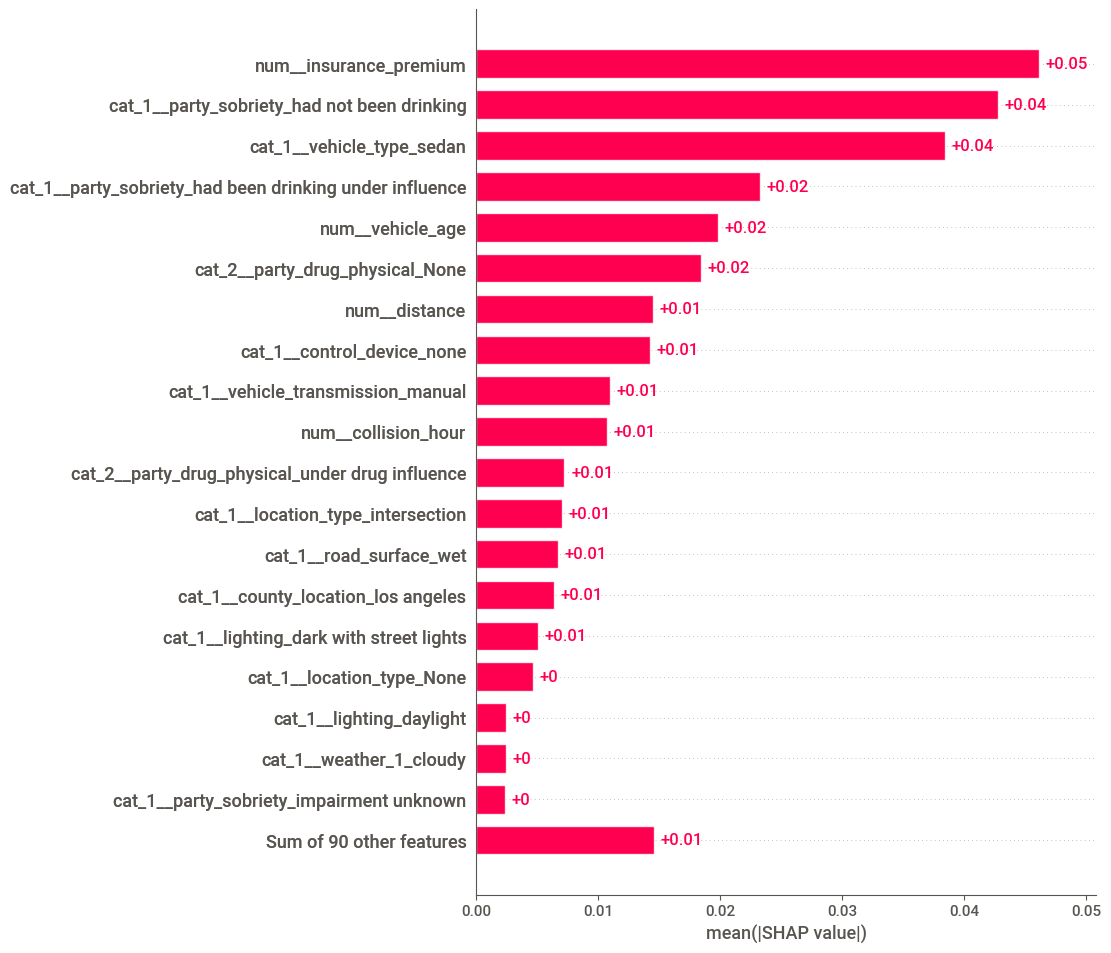

In [112]:
shap.plots.bar(shap_values[:,:,1], max_display=20)

Наши самые важные особенности:
- insurance premium
- party_sobriety
  vehicle_type
- vehicle_age
- control_device
- distance

Наименее влиятельный:

- collision_day
- county_city_location
- weather_1
- intersection
- road_condition_1
- lighting
- cellphone_in_use'

## Вторая кросс-валидация

In [113]:
# Подготовим наш целевой признак к моделированию
df_1 = df.drop(['weather_1'], axis=1)

In [114]:
# Проверка количества явных дубликатов
sum_dupli = df_1.duplicated().sum()
print(f'Есть {sum_dupli} дубликаты')

Есть 5 дубликаты


In [115]:
# Удаление дубликаты
df_1 = df_1.drop_duplicates()

In [116]:
# Проверка количества явных дубликатов
sum_dupli = df_1.duplicated().sum()
print(f'Есть {sum_dupli} дубликаты')

Есть 0 дубликаты


In [117]:
X_1 = df_1.drop('at_fault', axis=1)

y_1 = df_1['at_fault']

TEST_SIZE = 0.25

# Разделение на треннировчной и тестовой
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
                                    X_1,
                                    y_1,
                                    random_state=RANDOM_STATE,
                                    test_size=TEST_SIZE,
                                    stratify=y_1)

In [118]:
cat_columns_12 = [ 'county_location', 'collision_day', 'road_surface', 'road_condition_1', 'control_device', 
                  'lighting', 'location_type', 'vehicle_type', 'party_sobriety',  'vehicle_transmission', 
                  'cellphone_in_use']
cat_columns_22 = ['party_drug_physical']


# Количетьвеное значение
num_columns_12 = ['insurance_premium', 'vehicle_age', 'collision_hour', 'distance']

ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# создаём пайплайн для категорильного значения
cat_pipe_12 = Pipeline([
    ('imp_1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('enc', ohe)
])

cat_pipe_22 = Pipeline([
    ('imp_2', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='normal_condition')),
    ('enc', ohe)
])

num_pipe_12 = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('scal', MinMaxScaler())
])

# создаём общий пайплайн для подготовки данных
data_preprocessor_1 = ColumnTransformer(
    [('cat_1', cat_pipe_12, cat_columns_12),
     ('cat_2', cat_pipe_22, cat_columns_22),
     ('num', num_pipe_12, num_columns_12)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_1 = Pipeline([
    ('preprocessor', data_preprocessor_1),
    ('models', [lgb.LGBMClassifier(random_state=RANDOM_STATE)])
])

In [119]:
randomized_search_1 = RandomizedSearchCV(
        pipe_1,
        param_grid,
        cv=5,
        scoring='roc_auc',
        random_state=RANDOM_STATE,
        error_score="raise",
        n_jobs=-1
)
randomized_search_1.fit(X_train_1, y_train_1)

/home/regis/anaconda3/envs/gpu_env_torch/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/regis/anaconda3/envs/gpu_env_torch/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/regis/anaconda3/envs/gpu_env_torch/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/regis/anaconda3/envs/gpu_env_torch/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/regis/anaconda3/envs/gpu_env_torch/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X d

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat_1',
                                                                               Pipeline(steps=[('imp_1',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('enc',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['county_location',
                                                                                'collision_day',
                                                                                'road_surface',
                                                                                '...
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': [0.001, 0.01, 0.1],
                                         'models__penalty': ['l1', 'l2'],
                                         'models__solver': ['liblinear',
                                                            'saga']},
                                        {'models': [RandomForestClassifier(random_state=42)],
                                         'models__max_depth': [2, 14, 25],
                                         'models__max_features': [2, 14],
                                         'models__min_samples_leaf': [2, 14],
                                         'models__min_samples_split': [2, 14],
                                         'models__n_estimators': [48, 56]}],
                   random_state=42, scoring='roc_auc')

## Самая лучая модел после второй кросс-валидаций 

In [120]:
# Итог гиперпараметр тюнинг
report_randomised_search_1 = pd.DataFrame(randomized_search_1.cv_results_)
pd.set_option('display.max_colwidth', None)
report_randomised_search_1\
.sort_values('rank_test_score', ascending=True)[['param_models', 'params',\
                                                 'mean_fit_time', 'mean_score_time',\
                                                 'mean_test_score', 'rank_test_score']].head(5)

param_models  \
9  RandomForestClassifier(random_state=42)   
3          LGBMClassifier(random_state=42)   
7          LGBMClassifier(random_state=42)   
4          LGBMClassifier(random_state=42)   
5  RandomForestClassifier(random_state=42)   

                                                                                                                                                                                                 params  \
9  {'models__n_estimators': 56, 'models__min_samples_split': 2, 'models__min_samples_leaf': 14, 'models__max_features': 14, 'models__max_depth': 14, 'models': RandomForestClassifier(random_state=42)}   
3             {'models__num_leaves': 2, 'models__n_estimators': 200, 'models__min_data_in_leaf': 100, 'models__max_depth': 25, 'models__learning_rate': 0.1, 'models': LGBMClassifier(random_state=42)}   
7             {'models__num_leaves': 2, 'models__n_estimators': 200, 'models__min_data_in_leaf': 100, 'models__max_depth': 12, 'models__learning_rate': 0.1, 'models': LGBMClassifier(random_state=42)}   
4                {'models__num_leaves': 2, 'models__n_estimators': 200, 'models__min_data_in_leaf': 1, 'models__max_depth': 3, 'models__learning_rate': 0.1, 'models': LGBMClassifier(random_state=42)}   
5   {'models__n_estimators': 48, 'models__min_samples_split': 14, 'models__min_samples_leaf': 2, 'models__max_features': 2, 'models__max_depth': 25, 'models': RandomForestClassifier(random_state=42)}   

   mean_fit_time  mean_score_time  mean_test_score  rank_test_score  
9       1.809627         0.079556         0.726610                1  
3       0.596849         0.062905         0.721225                2  
7       0.687031         0.060802         0.721225                2  
4       0.615452         0.067218         0.721144                4  
5       1.249729         0.121029         0.714964                5

In [121]:
model_1 = randomized_search_1.best_estimator_
model_1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_1',
                                                  Pipeline(steps=[('imp_1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['county_location',
                                                   'collision_day',
                                                   'road_surface',
                                                   'road_condition_1',
                                                   'control_device', 'lighting',
                                                   'locatio...
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['party_drug_physical']),
                                                 ('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scal',
                                                                   MinMaxScaler())]),
                                                  ['insurance_premium',
                                                   'vehicle_age',
                                                   'collision_hour',
                                                   'distance'])])),
                ('models',
                 RandomForestClassifier(max_depth=14, max_features=14,
                                        min_samples_leaf=14, n_estimators=56,
                                        random_state=42))])

In [122]:
# Обучение нашей модели
model_1.fit(X_train_1, y_train_1)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_1',
                                                  Pipeline(steps=[('imp_1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['county_location',
                                                   'collision_day',
                                                   'road_surface',
                                                   'road_condition_1',
                                                   'control_device', 'lighting',
                                                   'locatio...
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['party_drug_physical']),
                                                 ('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scal',
                                                                   MinMaxScaler())]),
                                                  ['insurance_premium',
                                                   'vehicle_age',
                                                   'collision_hour',
                                                   'distance'])])),
                ('models',
                 RandomForestClassifier(max_depth=14, max_features=14,
                                        min_samples_leaf=14, n_estimators=56,
                                        random_state=42))])

# Лучшая модель в работе

## Предсказание и матрс ошибок

Модель:RandomForestClassifier
Площадь ROC-кривой: 0.7306539146676421
Метрика Recall на тестовой выборке: 0.5593245666467423
Метрика Precision на тестовой выборке: 0.7188400230458998
Время обучения в секундах:1.8096273422241211
Время предсказания в секундах:0.0795562744140625


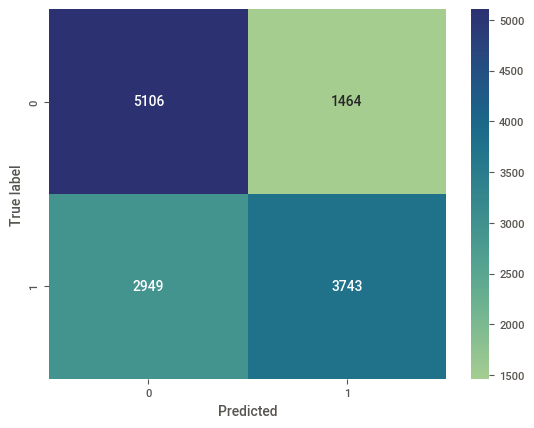

In [123]:
# Наш пердсказание для lgbm
y_pred = model_1.predict(X_test_1)

# Вероятность предсказания
y_pred_proba = model_1.predict_proba(X_test_1)

#
y_pred_proba_one = y_pred_proba[:,1]

print(f'Модель:'
      f'{str(report_randomised_search_1.query("rank_test_score==1")["param_models"].values[0]).split("(")[0]}')

print('Площадь ROC-кривой:', roc_auc_score(y_test_1, y_pred_proba_one))

print(f'Метрика Recall на тестовой выборке: {recall_score(y_test_1, y_pred)}')
print(f'Метрика Precision на тестовой выборке: {precision_score(y_test_1, y_pred)}')
print(f'Время обучения в секундах:'
      f'{report_randomised_search_1.query("rank_test_score==1")["mean_fit_time"].values[0]}')
print(f'Время предсказания в секундах:'
      f'{report_randomised_search_1.query("rank_test_score==1")["mean_score_time"].values[0]}')

cm = confusion_matrix(y_test_1, y_pred)
cm_plot = sns.heatmap(cm, annot=True, fmt='d', cmap='crest')
plt.ylabel('True label')
plt.xlabel('Predicted');

Наш метрик roc_auc около 73%, это не очень высоко из-за того что наверно не хватает признаков.

Истинно отрицательный = 5106 водители не виноваты которых модель правильно предсказала.

Истинно положительный = 3743, водители виноваты которых модель правильно предсказала.

Ошибка первого рода = 1464, водители не виноваты, которых модель не правильно предсказала, предсказала что они виноваты.

Ошибка второго рода = 2949, водители виноваты, которых модель не правильно предсказала, предсказала что они не виноваты.

Мы хотим уменьшить нашу ошибку второго рода. Это не страншо, если модель предсказывает, что водитель будет виноват, и это не так, но это может быть критично, если модель предсказывает, что водитель не будет виноват, но на самом деле он виноват, потому что ДТП этом случае может привести к смертельном.

## В поисках оптимального порога

Поскольку ДТП может привести к летальному исходу, мы попытаемся найти порог, при котором наша ошибка второго рода равна нулю.

In [174]:
# Получаем все вероятности получить класс 1 - вкусное молоко
data = pd.DataFrame(zip(y_test_1, y_pred_proba_one),
             columns = ['y_test', 'y_proba']).sort_values(by='y_proba',ascending=False)

data_0 = data.copy()

# Определяем порог

thresholds = [round(i,2) for i in np.linspace(0,1,num = 20,endpoint=False)]

# создаём переменные, которые будут хранить список новых колонок
columns = []
n_tp = []
n_fp = []
n_fn = []
thresholds_list = []

# добавляем столбцы с новыми предсказаниями в таблицу
for i in thresholds:
    tp = 0
    # Датафрейм data
    columns.append('y_pred_'+ str(i))
    y_pred = data['y_proba'].apply(lambda x: 1 if x >= i else 0)
    data['y_pred_'+ str(i)] = y_pred

    tn, fp, fn, tp = confusion_matrix(data['y_test'], y_pred).ravel()

    n_tp.append(tp)
    n_fp.append(fp)
    n_fn.append(fn)
    thresholds_list.append(i)
    y_pred=[]

df_threshold = pd.DataFrame({
    'thresholds': thresholds_list,
    'количество_true_positive':n_tp,
    'количество_false_positive':n_fp,
    'количество_false_negative':n_fn
    })

In [175]:
df_threshold['recall'] = df_threshold['количество_true_positive']/(df_threshold['количество_true_positive']+df_threshold['количество_false_negative'])
df_threshold['precision'] = df_threshold['количество_true_positive']/(df_threshold['количество_true_positive']+df_threshold['количество_false_positive'])
df_threshold.sort_values(by='recall').head(20)

thresholds  количество_true_positive  количество_false_positive  \
19        0.95                       310                          9   
18        0.90                       875                         26   
17        0.85                      1166                         50   
16        0.80                      1374                         81   
15        0.75                      1577                        113   
14        0.70                      1796                        197   
13        0.65                      2097                        327   
12        0.60                      2527                        547   
11        0.55                      3122                        909   
10        0.50                      3743                       1464   
9         0.45                      4379                       2167   
8         0.40                      5101                       3115   
7         0.35                      6069                       4860   
6         0.30                      6572                       6125   
5         0.25                      6674                       6499   
4         0.20                      6692                       6568   
3         0.15                      6692                       6570   
2         0.10                      6692                       6570   
1         0.05                      6692                       6570   
0         0.00                      6692                       6570   

    количество_false_negative    recall  precision  
19                       6382  0.046324   0.971787  
18                       5817  0.130753   0.971143  
17                       5526  0.174238   0.958882  
16                       5318  0.205320   0.944330  
15                       5115  0.235655   0.933136  
14                       4896  0.268380   0.901154  
13                       4595  0.313359   0.865099  
12                       4165  0.377615   0.822056  
11                       3570  0.466527   0.774498  
10                       2949  0.559325   0.718840  
9                        2313  0.654363   0.668958  
8                        1591  0.762253   0.620862  
7                         623  0.906904   0.555312  
6                         120  0.982068   0.517603  
5                          18  0.997310   0.506642  
4                           0  1.000000   0.504676  
3                           0  1.000000   0.504600  
2                           0  1.000000   0.504600  
1                           0  1.000000   0.504600  
0                           0  1.000000   0.504600

In [176]:
optimal_threshold = df_threshold.query('количество_false_negative == 0')['thresholds'].max()
print(f'Оптимальный порог:{optimal_threshold}')

Оптимальный порог:0.2


In [195]:
data_0.head()

y_test   y_proba colision_damage collision_damage
11983       1  0.983097   severe damage    severe damage
8701        1  0.982117    small damage     small damage
6371        1  0.981013   middle damage    middle damage
7518        1  0.980907   middle damage    middle damage
5502        1  0.980672    small damage     small damage

## Матрицы путаницы в зависимости от тяжести аварии

Очень важно сократить количество смертельных случаев. Давайте посмотрим, способна ли наша модель лучше выявлять виновных водителей в случае смертельных случаев или аварий с серьезными повреждениями, чем в случаях аварий с другими повреждениями.

In [180]:
data_0['collision_damage'] = df_0['collision_damage']

### ДТП со смертельным исходом

Площадь ROC-кривой: 0.7246749161073827
Метрика Recall на тестовой выборке: 0.5436241610738255
Метрика Precision на тестовой выборке: 0.75


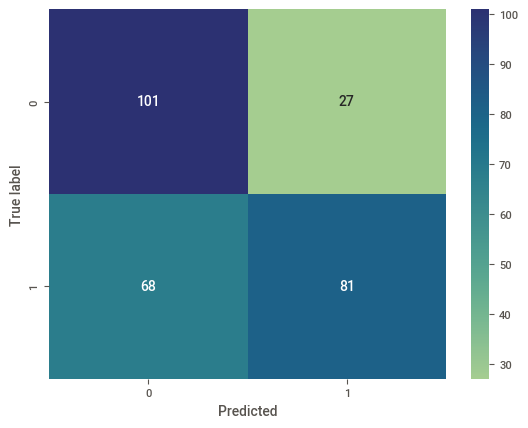

In [194]:
data_0_fatal = data_0.query('collision_damage == "fatal"')

print('Площадь ROC-кривой:', roc_auc_score(data_0_fatal['y_test'], data_0_fatal['y_proba']))

print(f'Метрика Recall на тестовой выборке: {recall_score(data_0_fatal["y_test"], round(data_0_fatal["y_proba"]))}')
print(f'Метрика Precision на тестовой выборке: {precision_score(data_0_fatal["y_test"], round(data_0_fatal["y_proba"]))}')

cm_fatal = confusion_matrix(data_0_fatal['y_test'], round(data_0_fatal['y_proba']))
cm_plot_fatal = sns.heatmap(cm_fatal, annot=True, fmt='d', cmap='crest')
plt.ylabel('True label')
plt.xlabel('Predicted');

### ДТП с серьезными повреждениями

Площадь ROC-кривой: 0.7496128772724517
Метрика Recall на тестовой выборке: 0.5804195804195804
Метрика Precision на тестовой выборке: 0.7238372093023255


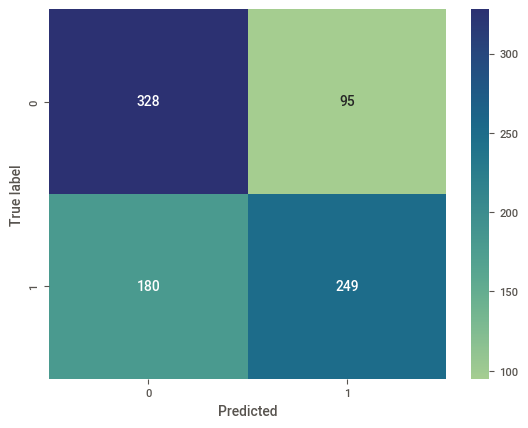

In [196]:
data_0_severe = data_0.query('collision_damage == "severe damage"')

print('Площадь ROC-кривой:', roc_auc_score(data_0_severe['y_test'], data_0_severe['y_proba']))

print(f'Метрика Recall на тестовой выборке: {recall_score(data_0_severe["y_test"], round(data_0_severe["y_proba"]))}')
print(f'Метрика Precision на тестовой выборке: {precision_score(data_0_severe["y_test"], round(data_0_severe["y_proba"]))}')

cm_severe = confusion_matrix(data_0_severe['y_test'], round(data_0_severe['y_proba']))
cm_plot_severe = sns.heatmap(cm_severe, annot=True, fmt='d', cmap='crest')
plt.ylabel('True label')
plt.xlabel('Predicted');

Из представленных выше матриц путаницы видно, что модель не выявляет больше виновных водителей, если авария приводит к летальному исходу или влечет за собой серьезные повреждения.

## Работа на party_sobriety

### Влияние трезвости на ущерб при столкновении

Одним из наиболее важных признаков является party_sobriety. Ранее в отчете, мы уже изучали некоторые графики, показывающие, как признак party_sobriety влияет на количество ДТП. Там увидели что 21% ДТП со смертельным исходом произошел из-за вождении под воздействием (dui).

In [125]:
table_damage = df_0.query('at_fault == 1')\
.pivot_table(index=['party_sobriety', 'collision_damage'], values='at_fault', aggfunc='count')
table_damage

at_fault
party_sobriety                         collision_damage          
had been drinking, impairment unknown  fatal                   53
                                       middle damage           72
                                       severe damage           31
                                       small damage            64
had been drinking, not under influence fatal                   41
                                       middle damage          210
                                       severe damage           40
                                       small damage           136
had been drinking, under influence     fatal                  546
                                       middle damage         2050
                                       severe damage          554
                                       small damage          1127
had not been drinking                  fatal                  943
                                       middle damage         8067
                                       severe damage         1290
                                       small damage         11453
impairment unknown                     fatal                   92
                                       middle damage          240
                                       severe damage          139
                                       small damage           502
not applicable                         middle damage           56
                                       severe damage            3
                                       small damage            46

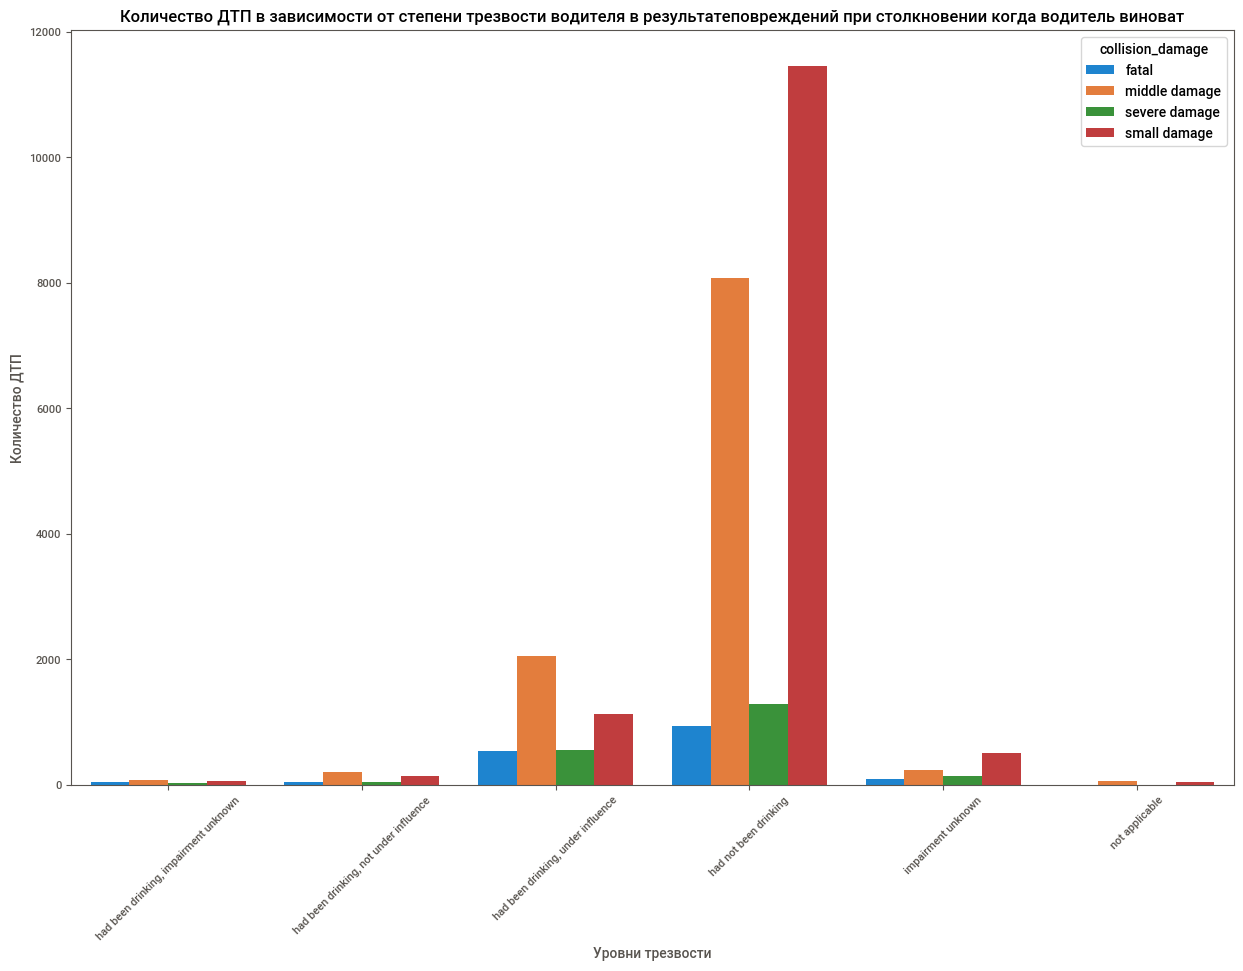

In [126]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data=table_damage, \
            x='party_sobriety', y='at_fault',
            hue='collision_damage');
ax.set_title('Количество ДТП в зависимости от степени трезвости водителя в результате' 
             'повреждений при столкновении когда водитель виноват') 
ax.set_xlabel('Уровни трезвости');
plt.xticks(rotation=45) 
ax.set_ylabel('Количество ДТП');

Мы ясно видим, что большинство ДТП спровоцировано непьющим водителем. Однако большинство из них приводят к небольшим или средним повреждениям. 

Дорожно-транспортные происшествия со смертельным исходом составляют менее 3% от общего числа ДТП для водителей, не употребляющих алкоголь, но составляют 12% дорожно-транспортных происшествий для водителей, находящихся в нетрезвом состоянии.

### Идеи, как не дать водителю в нетрезвом состоянии воспользоваться арендованным автомобилем

Компания могла бы разработать системы выявления нарушений, это сработало бы в случае, если водитель принял наркотики. Вот три примера системы, которую можно спроектировать:
 - система распознавания отпечатков пальцев: раньше водителю приходилось предоставлять свои отпечатки пальцев. Целью будет ответить на вопрос, используя капчу на экране.  Для этого водитель должен правильно нацелиться на то, к чему его просят прикоснуться на экране. Объект будет достаточно мал, чтобы затруднить выполнение запроса в случае нарушения. В то же время экран сможет определить, правильные ли это отпечатки пальцев человека, который утверждает, что находится в машине.
 - система, использующая распознавание сетчатки глаза: водителю придется показать один глаз камере. Раньше во время подписки водителю нужно было предоставить сканирование сетчатки одного глаза. Целью будет сначала распознать личность водителя, а также проверить, трезв он или нет. Согласно этому исследованию https://pubmed.ncbi.nlm.nih.gov/27404407/, можно с 99% уверенностью определить, пьян ли человек, проверив его глаза и используя тепловизионную подпись.
 - система, использующая распознавание голоса: водителю придется произнести фразу, которую он заранее записал во время подписки. Когда он сядет и заведет машину, например, чтобы разблокировать сцепление, ему придется сказать то же самое предложение в один микрофон. Сначала мы узнаем, что это настоящий человек, а затем благодаря такому алгоритму, как Audio-based Deep Learning Algorithm to Identify Alcohol Inebriation (ADLAIA), мы сможем узнать, пьян ли водитель или нет.

# Выводы

Предоставленные данные представляли собой данные об ДТП из Калифорнии, очень туристического штата, где в откябре происходит много ДТП из-за всего событии связаны с халловуйном.
Мы провели некоторое исследование всей таблицы с помощью sql-запроса. Оттуда мы узнаем, что большая часть ДТП когда водитель, употреблявший алкоголь, наркотики или уставший, происходил в выходные дни (начиная с вечера пятницы), и эти ДТП часто заканчивались смертельным исходом или приводили к серьезным повреждениям. Таким образом, система, которую хочет внедрить компания, может спасти жизнь.

Мы извлекли наш датафрейме из таблиц базы данных со следующими условиями:
    - Для модели выбрали тип виновника — только машина (car).
    - Выбрали случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
    - Для моделирования ограничиться данными за 2012 год — они самые свежие.

В нашей таблице было много пропущенных значений в party_drug_physical которие заменяли с помощью SimpleImputer по стратегией «constant», и несколько в другиых стольцах который заменяли с помощью SimpleImputer по стратегией «most_frequent».

EDA выявило, при каких значениях признаков произошло наибольшее количество дорожно-транспортных происшествий, однако на нашу переменную at_fault могут влиять разные факторы. Например, нарушением, из-за которого происходит большая часть дорожно-транспортных происшествий, является превышение скорости. Однако наиболее влиятельным нарушением для нашей целевой переменной было dui (вождение в нетрезвом виде).

Как только мы выяснили, какие признаки являются наиболее важными, с помощью EDA и корреляционной матрицы, мы используем наш набор признаков посредством двух кросс валидации, чтобы иметь возможность создать лучшую модель.

Нашей лучшей моделью оказалась модель RandomForestClassifier, что дало нам в тестовом наборе данных ROC AUC равно 73%, на пороге 0,5 она лучшее предсказываеть объект класс 0 чем объект класс 1 (полнота = 55,9% и точность 71,9%). Оптимальнйы порог что бы избегали от объектов класс 1 - 0,25.

Затем мы выясняем, что наиболее важными факторами нашей модели были:
- party_sobriety, которые дают нам информацию о трезвости водителя
- party_drug_physical, которые дают нам информацию о том, принимал ли водитель наркотики или был ли уставшим,
- insurance_premium, общая сумма страховки за год, которая через ее стоимость дает нам косвенную информацию о возрасте и водительском стаже водителя

Мы решили изучить признак party_sobriety, поскольку он, вероятно, является основной причиной ДТП со смертельным исходом. Мы предложили компании несколько идей, которые помогут определить, был ли водитель трезв или нет перед управлением автомобилем. 

Однако, что касается самой модели, я думаю, что будет сложно создать модель, которая могла бы эффективно предотвращать риски.

Возможно, модель сможет предотвратить ДТП со смертельным исходом или серьезные несчастные случаи из-за вождение под воздействием, что может спасти жизнь и само по себе это, вероятно, самое важное. Однако при небольшом повреждении или царапине это может быть сложнее, потому что много из них не зависеть от состояния водитель а можеть его поведение.

Нам не хватает некоторых признаки, чтобы сделать модель лучше, таких как возраст человека (даже если мы имеем представление об этом с учетом стоимости страховки insurance_premium), его психологический профиль (например, ответственный или нет) или даже данные из-за невнимательности. У нас есть данные об использовании мобильных телефонов, но есть и другие источники невнимательности, такие как еда, питье, дети и т. д.

Однако лучший способ избежать ДТП — это взять на себя ответственность за вождение, но это уже другая тема.